In [65]:
import pandas as pd, numpy as np
np.set_printoptions(suppress=True)# 关掉科学计数法
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels import regression

# import tushare as ts
import time, urllib
# ts.set_token('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')
# pro = ts.pro_api('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')

# import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)


# from plotly.graph_objs import Scatter,Layout
# import plotly
# import plotly.offline as py
# import numpy as np
# import plotly.graph_objs as go

# #setting offilne
# plotly.offline.init_notebook_mode(connected=True)

# Functions

- signal_generators: merge market data with technical analysis signals
- position calculators: calculate position based on a variety of principles (money-hedge/beta-hedge/risk-parity)
- ticker filters:
- backtester

# TechnicalIndicators

In [66]:
class TechnicalIndicators(object):

    def EMA(df, n, price_col): # n = 5
        """
        Exponential Moving Average
        rationale CHECKED, code CHECKED, updated.

        params:
            df: pd dataframe
            n: number of days = 5
        """
        EMA = df[price_col].ewm(span=n, min_periods=n - 1).mean().rename('EMA_' + str(n))
        return EMA

    def OBV(df, n, price_col, vol_col): # n = 5
        """On-balance Volume

        On Balance Volume (OBV) measures buying and selling pressure as a cumulative indicator that adds 
        volume on up days and subtracts volume on down days. OBV was developed by Joe Granville and introduced 
        in his 1963 book, Granville's New Key to Stock Market Profits. It was one of the first indicators to 
        measure positive and negative volume flow. Chartists can look for divergences between OBV and price 
        to predict price movements or use OBV to confirm price trends.

        http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:on_balance_volume_obv
        """
        df = df.reset_index()
        i = 0
        OBV = [0]
        while i < df.index[-1]:
            if df.at[i + 1, price_col] - df.at[i, price_col] > 0:
                OBV.append(df.at[i + 1, vol_col])
            if df.at[i + 1, price_col] - df.at[i, price_col] == 0:
                OBV.append(0)
            if df.at[i + 1, price_col] - df.at[i, price_col] < 0:
                OBV.append(-df.at[i + 1, vol_col])
            i = i + 1
        OBV = pd.Series(OBV)
        OBV_ma = pd.Series(OBV.rolling(window=n).mean(), name = 'OBV_' + str(n))
        return OBV_ma

    # Rationale checked
    def MFI(df, n, hi_col, lo_col, price_col, vol_col): # n = 14
        """Money Flow Index and Ratio, updated.
        http://stockcharts.com/docs/doku.php?id=scans:indicators#money_flow_index_mfi

        """
        df = df.reset_index()
        PP = (df[hi_col] + df[lo_col] + df[price_col]) / 3
        i  = 0
        PosMF = [0]
        while i < df.index[-1]:
            if PP[i + 1] > PP[i]:
                PosMF.append(PP[i + 1] * df.at[i + 1, vol_col])
            else:
                PosMF.append(0)
            i = i + 1
        PosMF = pd.Series(PosMF)
        TotMF = PP * df[vol_col]
        MFR   = pd.Series(PosMF / TotMF)
        MFI   = pd.Series(MFR.rolling(window = n, center = False).mean(), name = 'MFI_' + str(n))
        df    = df.join(MFI).set_index("index")
        return df["MFI_" + str(n)]

    # Done
    # Rationale checked
    def RSI(df, n, hi_col, lo_col): # n = 14
        """
        Relative Strength Index, updated.
        Conventional parameters: n = 14, 0.3 and 0.7 are two conventional thresholds
        """
        df = df.reset_index()
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.at[i + 1, hi_col] - df.at[i, hi_col]
            DoMove = df.at[i, lo_col] - df.at[i + 1, lo_col]
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else: UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else: DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI   = pd.Series(UpI)
        DoI   = pd.Series(DoI)
        PosDI = UpI.ewm(span = n, min_periods = n - 1).mean()
        NegDI = DoI.ewm(span = n, min_periods = n - 1).mean()
        RSI   = pd.Series(PosDI / (PosDI + NegDI), name = 'RSI_' + str(n))
        df    = df.join(RSI).set_index("index")
        return df["RSI_" + str(n)]

    def BIAS(df, n, price_col):
        BIAS = df[price_col]-df[price_col].rolling(window=n).mean().rename('BIAS_'+str(n))
        return BIAS

    def MACD(df, n_fast, n_slow, n_macd, price_col): # n_fast = 12, n_slow = 26
        """
        http://stockcharts.com/docs/doku.php?id=scans:indicators
        MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
        # Conventional look-back window for calculating MACDsign is 9
        """
        EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
        EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
        MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
        MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
        MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
        df['MACD_Diff'] = MACD
        df['MACD_Diff_EMA'] = MACDsign
        df['MACD'] = MACDdiff
        df['SIGNAL_STATUS'] = df['MACD'].apply(lambda x: "多头状态" if x>0 else ("空头状态" if x<0 else "无信号状态"))
        return df

# TimeSeriesToolbox

In [67]:
class GetData(object):
    
    def get_date_price_code_df(path, ticker_list, date_col, price_col, code_col):
        # for etf data cols are 'date', 'close', 'code'
        ticker_df_list = []
#         print(ticker_list)
        for ticker in ticker_list:
            print(ticker)
            try:
#                 print("get thru")
                
                ticker_df = pd.read_csv(path+ticker+".csv")
                ticker_df[code_col] = ticker_df[code_col].astype(str)
                ticker_df = ticker_df.sort_values(date_col)
                ticker_df = ticker_df[[date_col, price_col, code_col]]
#                 print(ticker_df)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
#         print(tickers_data_concated)
        return tickers_data_concated

In [68]:
class TimeSeriesToolbox(object):
        
    def make_numeric_signals(series):
        for item in series:
            if item =="多":
                return 1
            elif item =="空":
                return -1
            else:
                return 0 
            
    def merge_weights_and_signal(df_actions,
                                 df_wts,
                                 path,
                                 code_col,
                                 date_col,
                                 price_col,
                                 tgt_wts_mutiplier,
                                 account_value):
        if df_actions.empty:
            print("There's no data in df_actions. No actional signals for today!")
            pass
            
        else:
            # 合并仓位数据和信号数据
            df_actions_with_weights = df_wts.merge(df_actions, on =code_col)

            # 仓位太小，创建2倍仓位信息, e.g. tgt_wts_mutiplier = 2
            df_actions_with_weights['weight_enlarged'] = df_actions_with_weights['weight']*tgt_wts_mutiplier
    #         print(df_actions_with_weights)
            # 提取下一日要操作的tickers
            tickers = list(df_actions_with_weights[code_col])
    #         print(tickers)
            # 得到这些tickers的收盘价数据
    #         print(tickers)
            tickers_closes = GetData.get_date_price_code_df(path,
                                                             tickers,
                                                             date_col, 
                                                             price_col, 
                                                             code_col)
    #         print(tickers_closes)
            # 创建今日date信息
            last_date = tickers_closes[date_col].values[-1]
    #         print(last_date)
            # 提取最近一天的tickers的收盘价数据
            tickers_closes_last_date = tickers_closes[tickers_closes[date_col] == last_date]

            # 创建最终的信号-仓位指示信息
            df_actions_with_weights = df_actions_with_weights.merge(tickers_closes_last_date, on = [date_col,
                                                                                                    code_col])
            df_actions_with_weights['tgt_shares'] = account_value*\
                                                    df_actions_with_weights['weight_enlarged']/\
                                                    df_actions_with_weights[price_col]
            return df_actions_with_weights
     
    def merge_current_pos_with_target_pos(path, cur_positions, tgt_last_macd_signals):
        tgt_last_macd_signals['TYPE'] = "TARGET"
        # the following variables should be assigned first
        cur_pos_macd = MACDSignals(path, 
                        cur_positions, 
                        date_col, 
                        code_col, 
                        price_col, 
                        n_fast, 
                        n_slow, 
                        n_macd, 
                        ticker_type)
        cur_pos_macd_signals, \
        cur_pos_last_macd_signals, \
        cur_pos_df_actions = cur_pos_macd.calc_macd_signals()
        cur_pos_last_macd_signals['TYPE'] = 'CUR_POS'
        tgt_cur_macd_signal_df = cur_pos_last_macd_signals.merge(tgt_last_macd_signals, on = [date_col,code_col], how = 'outer')
        return tgt_cur_macd_signal_df

# PlotToolbox

In [69]:
class PlotToolbox(object):
    
    def pie_graph(values, labels, pie_length, pie_width, title_name):
        # draw pie graph
        plt.figure(1, figsize = (pie_length, pie_width))
        plt.axes(aspect=1)
        plt.pie(x=values, labels=labels, autopct='%3.1f %%')
        plt.title(title_name, fontsize = 15)
        plt.show()
        
        
    def plot_macd_signals(ticker, macd_signals, tail_num):
        ticker_macd_signals = macd_signals[macd_signals[code_col]==ticker]
        ticker_macd_signals.set_index(date_col, inplace = True)
        ticker_macd_signals[[code_col,"MACD"]].tail(tail_num).plot(figsize = (15,6))

In [70]:
# 在分析环境里，筛选出tickers，然后使用MACD_signals

class MACDSignals(object):
    
    def __init__(self, stocks_path, tickers, date_col, code_col, price_col, n_fast, n_slow, n_macd, ticker_type):
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.n_fast = n_fast
        self.n_slow = n_slow
        self.n_macd = n_macd
        self.ticker_type = ticker_type
        self.mkt_data = self.get_mkt_data_df()

    def get_mkt_data_df(self):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
        csv_path = self.path+"*.csv"
        files = glob.glob(csv_path)
        ticker_df_list = []
        for ticker in tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df[self.code_col] = ticker_df[self.code_col].astype(str)
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
        return tickers_data_concated
    

    def calc_macd_signals(self):
        tickers_data_concated = self.mkt_data
#         print(tickers_data_concated)
        signal_record = []
        signal_data = []
        if len(self.tickers)!=1:
            for ticker in self.tickers:
                try:
                    if self.ticker_type == "float":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==float(ticker)]
                    elif self.ticker_type == "string":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==ticker]
                        
                    signal_df = TechnicalIndicators.MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
                    
                    signal_data.append(signal_df)
                except:
                    pass
            signal_data_df = pd.concat(signal_data)
        else:
            try:                
                signal_df = TechnicalIndicators.MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
            except:
                pass
            signal_data_df = signal_df

        # v1 is the version of generating the og macd signals
        signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: TimeSeriesToolbox.make_numeric_signals(x))
        signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([self.code_col])['SIGNAL_DIRECTION'].diff()
        signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
#         print(signal_data_df)
        most_recent_signals = signal_data_df.groupby([self.code_col])[[self.date_col,self.code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
        df_actions = most_recent_signals[most_recent_signals["SIGNAL_ACTION"]!="NO CHANGE"]
        return signal_data_df, most_recent_signals, df_actions

In [71]:
from scipy.optimize import minimize

class RiskParity(object):
    
    def __init__(self, stocks_path, tickers, 
                 date_col, code_col, price_col, 
                 ticker_type, asset_name, draw_pie_graph):
        
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.ticker_type = ticker_type
        self.asset_name = asset_name
        self.draw_pie_graph = draw_pie_graph
        self.ticker_df_list = self.get_date_price_code_return_list()
        self.tgt_returns = self.ticker_df_list
        self.tgt_merged_returns = self.merge_dfs_by_ticker(self.tgt_returns, 
                                                           self.date_col)
        self.wts, self.risk = self.get_smart_weight(self.tgt_merged_returns, 
                                                    method='risk parity', 
                                                    cov_adjusted=False, 
                                                    wts_adjusted=False)
        self.df_wts, self.risk_parity_tickers, self.weights = self.get_df_wts()
        
        
    # Get date_col, price_col, code_col, pct_chg_col
    def get_date_price_code_return_list(self):
        # for etf data cols are 'date', 'close', 'code'
        ticker_df_list = []
        for ticker in self.tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df = ticker_df[[self.date_col, 
                                       self.price_col, 
                                       self.code_col]]
                ticker_df['pct_chg'] = ticker_df[self.price_col].pct_change()
                ticker_df = ticker_df[[self.date_col, 'pct_chg']].dropna()
                ticker_df.columns = [self.date_col, ticker]
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        return ticker_df_list
    
    
    def merge_dfs_by_ticker(self, ticker_df_list, date_col):
        merged_all = reduce(lambda left, right: pd.merge(left, right, on=date_col), ticker_df_list)
#         merged_all = reduce(merge_df_for_reduce, ticker_df_list)
        merged_all.set_index(self.date_col, inplace=True)
        merged_all.dropna(how="all", axis = 1, inplace = True)
        merged_all.fillna(method="ffill", inplace = True)
        return merged_all
        
        
    def get_smart_weight(self, pct, method='risk parity', cov_adjusted=False, wts_adjusted=False):
        if cov_adjusted == False:
            #协方差矩阵
            cov_mat = pct.cov()
        else:
            #调整后的半衰协方差矩阵
            cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
                pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
        if not isinstance(cov_mat, pd.DataFrame):
            raise ValueError('cov_mat should be pandas DataFrame！')

        omega = np.matrix(cov_mat.values)  # 协方差矩阵

        a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
        a = np.matrix(a)
        b = np.matrix(b)
        # 定义目标函数
    
        def fun1(x):
            tmp = (omega * np.matrix(x).T).A1
            risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
            delta_risk = [sum((i - risk)**2) for i in risk]
            return sum(delta_risk)

        def fun2(x):
            tmp = (b**(-1) * omega * np.matrix(x).T).A1
            risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
            delta_risk = [sum((i - risk)**2) for i in risk]
            return sum(delta_risk)
    
        # 初始值 + 约束条件 
        x0 = np.ones(omega.shape[0]) / omega.shape[0]  
        bnds = tuple((0,None) for x in x0)
        cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
        options={'disp':False, 'maxiter':1000, 'ftol':1e-20}

        if method == 'risk parity':
            res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
        elif method == 'pc risk parity':
            res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
        else:
            raise ValueError('method error！！！')

        # 权重调整
        if res['success'] == False:
            # print res['message']
            pass
        wts = pd.Series(index=cov_mat.index, data=res['x'])

        if wts_adjusted == True:
            wts[wts < 0.0001]=0.0
            wts = wts / wts.sum()
        elif wts_adjusted == False:
            wts = wts / wts.sum()
        else:
            raise ValueError('wts_adjusted should be True/False！')

        risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
        risk[risk<0.0] = 0.0
        return wts,risk
    
        
    def get_df_wts(self):
        df_wts = pd.DataFrame(self.wts)
        df_wts.reset_index(inplace = True)
        df_wts.columns = [self.asset_name, 'weight']
        risk_parity_tickers = list(df_wts[self.asset_name])
        weights = list(df_wts['weight'])
        return df_wts, risk_parity_tickers, weights


In [72]:
# Mannually check our current position holdings for potential exit signals:
cur_positions = [
#     "510180",#180ETF
#     "510300",#300ETF
#     "510810",#上海国企
#     "510850",#工银上50
    '512000', #券商ETF
#     '512010',#医药ETF
#     "512400",#有色ETF
#     '512690',#酒ETF
    '512800',#银行ETF
    '512880',#证券ETF
    
#     '513050',#中概互联网
#     '513100',#纳指ETF
    '513500',#标普500
#     '518880',#黄金ETF
#     "159905",#深红利
#     "159920",#恒生ETF
#     "159959", #央企ETF
#     "159939"# 信息技术
    '510880',#红利ETF
#     ''#券商ETF

#     ''#证券ETF
#     ''#标普500
    
]
len(cur_positions)

5

In [73]:
# returns = {
#     "2020-03-02":0,
#     "2020-03-03":0,
#     "2020-03-04":0,
#     "2020-03-05":0,
#     "2020-03-06":0,
#     "2020-03-09":-0.21,
#     "2020-03-10":0.04,
#     "2020-03-11":-0.08,
#     "2020-03-12":-0.21,
#     "2020-03-13":-0.1,
#     "2020-03-16":0,
#     "2020-03-17":0,
#     "2020-03-18":0,
#     "2020-03-19":0,
#     "2020-03-20":0.01,
#     "2020-03-23":0,
#     "2020-03-24":0,
#     "2020-03-25":-0.01,
#     "2020-03-26":-0.02,
#     "2020-03-27":-0.41,
#     "2020-03-30":-0.39,
#     "2020-03-31":0.12,
#     "2020-04-01":-0.61,
#     "2020-04-02":0.82,
#     "2020-04-03":-0.18,
#     "2020-04-07":1.74,
#     "2020-04-08":-0.33,
#     "2020-04-09":0.42,
#     "2020-04-10":

# }
# returns_df = pd.DataFrame(pd.Series(returns), columns=['daily_rtrn'])
# returns_df = returns_df.reset_index().rename(columns = {"index":"date"})
# returns_df['daily_rtrn'] = returns_df['daily_rtrn']/100
# returns_df['sum_rtrn'] = returns_df['daily_rtrn'].cumsum()
# returns_df['equity_rtrn'] = returns_df['sum_rtrn']+1

In [74]:
print("Mark's total share returns:",2000*(5/9))
print("Brad's total share returns:",2000*(2/9))
print("Kevin's total share returns:",2000*(2/9))

Mark's total share returns: 1111.111111111111
Brad's total share returns: 444.4444444444444
Kevin's total share returns: 444.4444444444444


In [75]:
if __name__=="__main__":
    stocks_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    etfs_df = pd.read_csv("filtered_50_etfs_by_vol_20200224.csv")
    tickers = list(etfs_df['etf'].str.split(".",expand = True)[0])
#     date_col = 'trade_date'
#     code_col = 'ts_code'
#     price_col = 'close'
    date_col = 'date'
    code_col = 'code'
    price_col = 'close'
    ticker_type = 'string'
    asset_name = "code"
    tgt_wts_mutiplier = 2
    account_value = 90000
    
#     # ========For calculating MACD signals========
    n_fast = 12
    n_slow = 26
    n_macd = 9
    macd = MACDSignals(stocks_path, 
                        tickers, 
                        date_col, 
                        code_col, 
                        price_col, 
                        n_fast, 
                        n_slow, 
                        n_macd, 
                        ticker_type)
    macd_signals, last_macd_signals, df_actions = macd.calc_macd_signals()

    # ========For calculating risk-parity weights========
    risk_parity = RiskParity(stocks_path,
                              tickers,
                              date_col,
                              code_col,
                              price_col,
                              ticker_type,
                              asset_name,
                              True)
    
    df_wts, risk_parity_tickers, weights = risk_parity.get_df_wts()
    
    df_actions_with_weights = TimeSeriesToolbox.merge_weights_and_signal(df_actions,
                                                                     df_wts,
                                                                     stocks_path,
                                                                     code_col,
                                                                     date_col,
                                                                     price_col,
                                                                     tgt_wts_mutiplier,
                                                                     account_value)
#     PlotToolbox.pie_graph(weights, risk_parity_tickers, 8, 8, "Risk Parity Allocation")

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

159920
159915
512330
159949
159959


In [76]:
tgt_cur_pos_df = TimeSeriesToolbox.merge_current_pos_with_target_pos(stocks_path, cur_positions, last_macd_signals)

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# Reentry

In [77]:
def find_recent_goldcross_close(close, signal_diff):
    if signal_diff == 1 or signal_diff == 2:
        return close

macd_signals['recent_goldcross'] = macd_signals.apply(lambda row: find_recent_goldcross_close(row['close'],row['SIGNAL_DIRECTION_DIFF']), axis=1)

# forward-fill all NaNs for the recent_goldcross to pave way for calculating the pct_diff between current 
# close and the rencent goldcross close
macd_signals['recent_goldcross_ffill'] = macd_signals.groupby("code")['recent_goldcross'].apply(lambda x: x.fillna(method="ffill"))
macd_signals['pctchg_from_recent_goldcrossclose'] = (macd_signals['close']-macd_signals['recent_goldcross_ffill'])/macd_signals['recent_goldcross_ffill']
macd_signals['reentry_rank'] = macd_signals.groupby(["date"])['pctchg_from_recent_goldcrossclose'].rank(ascending = True)
last_day = macd_signals['date'].values[-1]
macd_signals_reentry = macd_signals[macd_signals['date']==last_day][macd_signals['pctchg_from_recent_goldcrossclose']<0]

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [78]:
all_reentry_tickers = list(macd_signals_reentry['code'])
tickers_to_reenter = []
for ticker in all_reentry_tickers:
    if ticker not in cur_positions:
        tickers_to_reenter.append(ticker)

In [79]:
tickers_to_reenter_df = pd.DataFrame(tickers_to_reenter, columns=['code'])
df_actions_with_weights_reentry = df_wts.merge(tickers_to_reenter_df, on = ['code'])
macd_signals_reentry = macd_signals[macd_signals['date']==last_day]
df_actions_with_weights_reentry = df_actions_with_weights_reentry.merge(macd_signals_reentry, on = 'code')
df_actions_with_weights_reentry['weight_enlarged'] = df_actions_with_weights_reentry['weight']*tgt_wts_mutiplier

In [80]:
df_actions_with_weights_reentry['tgt_shares'] = account_value*\
                                                    df_actions_with_weights_reentry['weight_enlarged']/\
                                                    df_actions_with_weights_reentry[price_col]

df_actions_with_weights_reentry = df_actions_with_weights_reentry[['code','date','SIGNAL_STATUS','SIGNAL_ACTION',\
                                                                   'weight_enlarged','close','tgt_shares',\
                                                                   'pctchg_from_recent_goldcrossclose','reentry_rank']]
df_actions_with_weights_reentry.sort_values('reentry_rank', ascending=True, inplace=True)

In [81]:
df_actions_with_weights_reentry_L = df_actions_with_weights_reentry[df_actions_with_weights_reentry['SIGNAL_STATUS']=="多头状态"]

In [82]:
df_actions_with_weights_reentry_L

,code,date,SIGNAL_STATUS,SIGNAL_ACTION,weight_enlarged,close,tgt_shares,pctchg_from_recent_goldcrossclose,reentry_rank
3,512900,2020-06-03,多头状态,NO CHANGE,0.031286,0.912,3087.447599,-0.011918,3.0
8,512980,2020-06-03,多头状态,NO CHANGE,0.031471,0.866,3270.663526,-0.004598,4.0
5,512100,2020-06-03,多头状态,NO CHANGE,0.033140,0.788,3785.071022,-0.002532,5.0
1,159901,2020-06-03,多头状态,NO CHANGE,0.032985,5.475,542.214125,-0.001823,6.0
0,510500,2020-06-03,多头状态,NO CHANGE,0.037420,6.045,557.117754,-0.001652,7.0
2,159905,2020-06-03,多头状态,NO CHANGE,0.037609,1.948,1737.589661,-0.001026,8.0
10,512180,2020-06-03,多头状态,NO CHANGE,0.040053,1.117,3227.228062,-0.000894,9.0
11,512160,2020-06-03,多头状态,NO CHANGE,0.040743,1.190,3081.406945,-0.000840,10.0
4,159922,2020-06-03,多头状态,NO CHANGE,0.037027,5.921,562.819060,-0.000506,11.0
6,510330,2020-06-03,多头状态,NO CHANGE,0.041928,3.988,946.207951,-0.000501,12.0


In [83]:
selected_reentry_tickers = list(df_actions_with_weights_reentry['code'])

In [84]:
selected_reentry_tickers

['512900',
 '512980',
 '512100',
 '159901',
 '510500',
 '159905',
 '512180',
 '512160',
 '159922',
 '510330',
 '512500',
 '510300']

# Check Current Positions

In [85]:
# Show if there are any actions needed to be made for our current positions
tgt_cur_pos_df[tgt_cur_pos_df['TYPE_x']=="CUR_POS"]

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y
0,2020-06-03,512000,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
1,2020-06-03,512800,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
2,2020-06-03,512880,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
3,2020-06-03,513500,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
4,2020-06-03,510880,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET


# Check if there's new positions to be entered

In [86]:
# Check if there are any new positions to be entered
tgt_cur_pos_df[(tgt_cur_pos_df['TYPE_x']!="CUR_POS")&(tgt_cur_pos_df['SIGNAL_ACTION_y']!="NO CHANGE")]

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y
7,2020-06-03,159920,NaN,NaN,NaN,多头状态,LONG,TARGET
23,2020-06-03,159915,NaN,NaN,NaN,多头状态,LONG,TARGET
25,2020-06-03,512330,NaN,NaN,NaN,多头状态,LONG,TARGET
30,2020-06-03,159949,NaN,NaN,NaN,多头状态,LONG,TARGET
42,2020-06-03,159959,NaN,NaN,NaN,多头状态,LONG,TARGET


In [87]:
df_actions_with_weights

,code,weight,date,SIGNAL_STATUS,SIGNAL_ACTION,weight_enlarged,close,tgt_shares
0,159920,0.028482,2020-06-03,多头状态,LONG,0.056964,1.369,3744.901503
1,159915,0.015839,2020-06-03,多头状态,LONG,0.031677,2.060,1383.962561
2,512330,0.013645,2020-06-03,多头状态,LONG,0.027290,1.097,2238.952335
3,159949,0.014978,2020-06-03,多头状态,LONG,0.029955,0.807,3340.759841
4,159959,0.022218,2020-06-03,多头状态,LONG,0.044435,0.963,4152.831349


In [88]:
df_actions_tickers = list(df_actions_with_weights['code'])

In [89]:
symbol_list_to_backtest = df_actions_tickers+selected_reentry_tickers
symbol_list_to_backtest

['159920',
 '159915',
 '512330',
 '159949',
 '159959',
 '512900',
 '512980',
 '512100',
 '159901',
 '510500',
 '159905',
 '512180',
 '512160',
 '159922',
 '510330',
 '512500',
 '510300']

# Backtest and filter

In [90]:
from CH_backtest import *

In [91]:
# symbol_list_to_backtest = [
# #             "518880", # 黄金ETF
# #             "513050",# 中概互联网
# #             "513100",# 纳指ETF
# #             "159920",# 恒生ETF
# #             "510900",# 【H股ETF：弃，MACD不赚钱】
# #             "512010",#医药ETF，
# #             "159902",#中小板
# #     "512660",
# #     "159939",#信息技术
# #     "159915",
# #     "159922",
# #     "159949",#创业板50
# #     "510510",
# #     "512100",
# #     "512980",#传媒ETF
# #     "159952",#创业ETF
# #     "512500",
#     "159959",
#     "512960",#央调ETF
#     "512950",
#     "512330",#信息技术ETF
#     "512000",
#     "512880",
#     "512900",
#     "512400"
# #  ===================================================
# #             "002559.SZ",
# #             "002638.SZ",
# #             "601899.SH",#紫金矿业
# #             "600208.SH",#新湖中宝、所属板块：参股券商
# #             "000069.SZ",#华侨城A
# #             "002524.SZ",#光正集团
# #             "600712.SH",#南宁百货
# #             "002610.SZ",#爱康科技
    
# ]

ticker_performances = {}

if __name__ == "__main__":
    for ticker in symbol_list_to_backtest:
    # csv_dir = REPLACE_WITH_YOUR_CSV_DIR_HERE
        equity_folder = "./"
        csv_dir = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    #     symbol_list = [

    # # ==============ETF================
    # #         "518880", # 黄金ETF
    # #         "513050",# 中概互联网
    # #         "513100",# 纳指ETF
    # #         "159920",# 恒生ETF
    # #         "510900",# 【H股ETF：弃，MACD不赚钱】
    # #         "512010",#医药ETF，
    # # ==============股票================
    # #         "002559.SZ",
    # #         "002638.SZ",
    # #         "601899.SH",#紫金矿业
    # #         "600208.SH",#新湖中宝、所属板块：参股券商
    # #         "000069.SZ",#华侨城A
    # #         "002524.SZ",#光正集团
    # #         "600712.SH",#南宁百货
    # #         "002610.SZ",#爱康科技
    # #         "601777.SH",#【力帆股份：基本面弱，暂弃】
    #         "002094.SZ",#青岛金王
    # #         "600467.SH"#【好当家：股价涨太高，暂时弃】

    #     ]
#         data_cols = ['trade_date', 'open', 'high','low', 'close', 'volume','ts_code'] #for ETFs # 要改代码
#         data_cols = ['ts_code','trade_date','open','high','low','close','pre_close','change','pct_chg','vol','amount'] #for stocks
#         commissions = 5 # RMB/USD per trade #要改代码
        initial_capital = 1000000.0
        start_date = datetime.datetime(1991,12,1,0,0,0)
        start_date_str = str(start_date)
        heartbeat = 0.0
#         price_col = "close" #要改代码
#         qty = 5000 # 要改代码
        backtest = Backtest(csv_dir, 
                            [ticker], 
                            initial_capital, 
                            heartbeat,
                            start_date,
                            HistoricCSVDataHandler, 
                            SimulatedExecutionHandler, 
                            Portfolio, 
    #                         MovingAverageCrossStrategy,
                           MovingAverageConvergenceDivergence)

        backtest.simulate_trading()
        df_equity = pd.read_csv(ticker+"_performance"+".csv")
        df_equity.drop_duplicates("datetime", inplace = True)
        df_equity =df_equity[df_equity['datetime']>start_date_str]
        df_equity.index = df_equity['datetime']
        df_equity = df_equity[df_equity['total'].map(lambda x: str(x)!="nan")]
        df_equity.columns = ['datetime', 'market_value', 'cash', 'commission', 'total', 'returns',
        'equity_curve', 'drawdown']
        df_equity_copy = df_equity.copy()
        data = df_equity_copy
#         win_rate, mean_win_loss_ratio, bt_score, profits = performance(data)
        single_stats = performance(data)
#         print("TICKER: ", ticker)
        ticker_performances[ticker] = single_stats

Number of assets in the portfolio：  1
Position Value for each asset:  1000000.0
Asset:  159920 symbol_value:  0.988 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.981 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.993 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.007 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.022 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.042 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.035 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.987 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.996 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.993 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.99 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.005 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.94 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.977 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.002 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.976 mkt_quantity:  5000
Asset:  159920 symbol_valu

Asset:  159920 symbol_value:  1.4480000000000002 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.472 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.47 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.476 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.489 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.456 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.459 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.5330000000000001 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.528 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.474 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.301 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.318 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.374 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.352 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.37 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.352 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.37 mkt_quantity:  5000
Asset:  159920 symbol_val

Holding the position:  2013-12-05
Holding the position:  2013-12-06
Holding the position:  2013-12-09
Closed the position:  2013-12-10
This trade's pnl: 100.0
-------------------
Position is empty:  2013-12-10
Position is empty:  2013-12-11
Position is empty:  2013-12-12
Position is empty:  2013-12-13
Position is empty:  2013-12-16
Position is empty:  2013-12-17
Position is empty:  2013-12-18
Position is empty:  2013-12-19
Position is empty:  2013-12-20
Position is empty:  2013-12-23
Position is empty:  2013-12-24
Position is empty:  2013-12-25
Position is empty:  2013-12-26
Position is empty:  2013-12-27
Position is empty:  2013-12-30
-------------------
Opened the position:  2013-12-31
Holding the position:  2014-01-02
Holding the position:  2014-01-03
Holding the position:  2014-01-06
Closed the position:  2014-01-07
This trade's pnl: -165.0
-------------------
Position is empty:  2014-01-07
Position is empty:  2014-01-08
Position is empty:  2014-01-09
Position is empty:  2014-01-10

Position is empty:  2015-02-16
Position is empty:  2015-02-17
Position is empty:  2015-02-25
-------------------
Opened the position:  2015-02-26
Holding the position:  2015-02-27
Holding the position:  2015-03-02
Holding the position:  2015-03-03
Holding the position:  2015-03-04
Holding the position:  2015-03-05
Closed the position:  2015-03-06
This trade's pnl: -100.0
-------------------
Position is empty:  2015-03-06
Position is empty:  2015-03-09
Position is empty:  2015-03-10
Position is empty:  2015-03-11
Position is empty:  2015-03-12
Position is empty:  2015-03-13
Position is empty:  2015-03-16
Position is empty:  2015-03-17
Position is empty:  2015-03-18
Position is empty:  2015-03-19
-------------------
Opened the position:  2015-03-20
Holding the position:  2015-03-23
Holding the position:  2015-03-24
Holding the position:  2015-03-25
Holding the position:  2015-03-26
Holding the position:  2015-03-27
Holding the position:  2015-03-30
Holding the position:  2015-03-31
Holdi

Holding the position:  2016-08-25
Holding the position:  2016-08-26
Holding the position:  2016-08-29
Holding the position:  2016-08-30
Holding the position:  2016-08-31
Holding the position:  2016-09-01
Holding the position:  2016-09-02
Holding the position:  2016-09-05
Holding the position:  2016-09-06
Holding the position:  2016-09-07
Holding the position:  2016-09-08
Holding the position:  2016-09-09
Holding the position:  2016-09-12
Holding the position:  2016-09-13
Holding the position:  2016-09-14
Holding the position:  2016-09-19
Holding the position:  2016-09-20
Holding the position:  2016-09-21
Holding the position:  2016-09-22
Holding the position:  2016-09-23
Holding the position:  2016-09-26
Closed the position:  2016-09-27
This trade's pnl: 335.0
-------------------
Position is empty:  2016-09-27
Position is empty:  2016-09-28
Position is empty:  2016-09-29
Position is empty:  2016-09-30
Position is empty:  2016-10-10
Position is empty:  2016-10-11
Position is empty:  201

Holding the position:  2017-11-13
Holding the position:  2017-11-14
Holding the position:  2017-11-15
Holding the position:  2017-11-16
Holding the position:  2017-11-17
Holding the position:  2017-11-20
Holding the position:  2017-11-21
Holding the position:  2017-11-22
Holding the position:  2017-11-23
Holding the position:  2017-11-24
Holding the position:  2017-11-27
Holding the position:  2017-11-28
Holding the position:  2017-11-29
Holding the position:  2017-11-30
Closed the position:  2017-12-01
This trade's pnl: 50.0
-------------------
Position is empty:  2017-12-01
Position is empty:  2017-12-04
Position is empty:  2017-12-05
Position is empty:  2017-12-06
Position is empty:  2017-12-07
Position is empty:  2017-12-08
Position is empty:  2017-12-11
Position is empty:  2017-12-12
Position is empty:  2017-12-13
Position is empty:  2017-12-14
Position is empty:  2017-12-15
Position is empty:  2017-12-18
Position is empty:  2017-12-19
-------------------
Opened the position:  201

Holding the position:  2019-02-01
Holding the position:  2019-02-11
Holding the position:  2019-02-12
Holding the position:  2019-02-13
Holding the position:  2019-02-14
Holding the position:  2019-02-15
Holding the position:  2019-02-18
Holding the position:  2019-02-19
Holding the position:  2019-02-20
Holding the position:  2019-02-21
Holding the position:  2019-02-22
Holding the position:  2019-02-25
Holding the position:  2019-02-26
Holding the position:  2019-02-27
Holding the position:  2019-02-28
Holding the position:  2019-03-01
Holding the position:  2019-03-04
Holding the position:  2019-03-05
Holding the position:  2019-03-06
Holding the position:  2019-03-07
Closed the position:  2019-03-08
This trade's pnl: 640.0
-------------------
Position is empty:  2019-03-08
Position is empty:  2019-03-11
Position is empty:  2019-03-12
Position is empty:  2019-03-13
Position is empty:  2019-03-14
Position is empty:  2019-03-15
Position is empty:  2019-03-18
-------------------
Opened

Asset:  159915 symbol_value:  0.653 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.733 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.758 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.7440000000000001 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.765 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.735 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.713 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.664 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.6940000000000001 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.7070000000000001 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.711 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.71 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.735 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.715 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.72 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.71 mkt_quantity:  5000
Asset:  159915 symbol_value:  0.708 mkt_quantity:  5000
Asset:  1599

Asset:  159915 symbol_value:  1.385 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.351 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.334 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.275 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.183 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.168 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.2009999999999998 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.274 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.2930000000000001 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.266 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.273 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.265 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.207 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.18 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.2229999999999999 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.581 mkt_quantity:  5000
Asset:  159915 symbol_value:  1.619 mkt_quantity:  5000
Asset:  15

Holding the position:  2012-06-18
Holding the position:  2012-06-19
Holding the position:  2012-06-20
Holding the position:  2012-06-21
Holding the position:  2012-06-25
Holding the position:  2012-06-26
Closed the position:  2012-06-27
This trade's pnl: -60.0
-------------------
Position is empty:  2012-06-27
Position is empty:  2012-06-28
Position is empty:  2012-06-29
Position is empty:  2012-07-02
Position is empty:  2012-07-03
Position is empty:  2012-07-04
Position is empty:  2012-07-05
Position is empty:  2012-07-06
Position is empty:  2012-07-09
Position is empty:  2012-07-10
Position is empty:  2012-07-11
Position is empty:  2012-07-12
Position is empty:  2012-07-13
Position is empty:  2012-07-16
Position is empty:  2012-07-17
Position is empty:  2012-07-18
Position is empty:  2012-07-19
Position is empty:  2012-07-20
Position is empty:  2012-07-23
Position is empty:  2012-07-24
Position is empty:  2012-07-25
-------------------
Opened the position:  2012-07-26
Holding the pos

Position is empty:  2013-08-21
Position is empty:  2013-08-22
-------------------
Opened the position:  2013-08-23
Holding the position:  2013-08-26
Holding the position:  2013-08-27
Holding the position:  2013-08-28
Holding the position:  2013-08-29
Holding the position:  2013-08-30
Holding the position:  2013-09-02
Holding the position:  2013-09-03
Holding the position:  2013-09-04
Holding the position:  2013-09-05
Holding the position:  2013-09-06
Holding the position:  2013-09-09
Holding the position:  2013-09-10
Holding the position:  2013-09-11
Holding the position:  2013-09-12
Holding the position:  2013-09-13
Closed the position:  2013-09-16
This trade's pnl: 115.0
-------------------
Position is empty:  2013-09-16
Position is empty:  2013-09-17
-------------------
Opened the position:  2013-09-18
Holding the position:  2013-09-23
Holding the position:  2013-09-24
Holding the position:  2013-09-25
Holding the position:  2013-09-26
Holding the position:  2013-09-27
Holding the p

Holding the position:  2014-09-16
Holding the position:  2014-09-17
Holding the position:  2014-09-18
Closed the position:  2014-09-19
This trade's pnl: 85.0
-------------------
Position is empty:  2014-09-19
Position is empty:  2014-09-22
Position is empty:  2014-09-23
Position is empty:  2014-09-24
-------------------
Opened the position:  2014-09-25
Holding the position:  2014-09-26
Holding the position:  2014-09-29
Holding the position:  2014-09-30
Holding the position:  2014-10-08
Holding the position:  2014-10-09
Holding the position:  2014-10-10
Holding the position:  2014-10-13
Holding the position:  2014-10-14
Holding the position:  2014-10-15
Holding the position:  2014-10-16
Holding the position:  2014-10-17
Closed the position:  2014-10-20
This trade's pnl: -80.0
-------------------
Position is empty:  2014-10-20
Position is empty:  2014-10-21
Position is empty:  2014-10-22
Position is empty:  2014-10-23
Position is empty:  2014-10-24
Position is empty:  2014-10-27
Position

Holding the position:  2015-10-09
Holding the position:  2015-10-12
Holding the position:  2015-10-13
Holding the position:  2015-10-14
Holding the position:  2015-10-15
Holding the position:  2015-10-16
Holding the position:  2015-10-19
Holding the position:  2015-10-20
Holding the position:  2015-10-21
Holding the position:  2015-10-22
Holding the position:  2015-10-23
Holding the position:  2015-10-26
Holding the position:  2015-10-27
Holding the position:  2015-10-28
Holding the position:  2015-10-29
Holding the position:  2015-10-30
Holding the position:  2015-11-02
Closed the position:  2015-11-03
This trade's pnl: 3105.0
-------------------
Position is empty:  2015-11-03
Position is empty:  2015-11-04
Position is empty:  2015-11-05
-------------------
Opened the position:  2015-11-06
Holding the position:  2015-11-09
Holding the position:  2015-11-10
Holding the position:  2015-11-11
Holding the position:  2015-11-12
Holding the position:  2015-11-13
Holding the position:  2015-

Position is empty:  2016-10-31
Position is empty:  2016-11-01
Position is empty:  2016-11-02
Position is empty:  2016-11-03
Position is empty:  2016-11-04
Position is empty:  2016-11-07
Position is empty:  2016-11-08
Position is empty:  2016-11-09
Position is empty:  2016-11-10
Position is empty:  2016-11-11
Position is empty:  2016-11-14
Position is empty:  2016-11-15
-------------------
Opened the position:  2016-11-16
Holding the position:  2016-11-17
Holding the position:  2016-11-18
Holding the position:  2016-11-21
Holding the position:  2016-11-22
Holding the position:  2016-11-23
Holding the position:  2016-11-24
Holding the position:  2016-11-25
Closed the position:  2016-11-28
This trade's pnl: -165.0
-------------------
Position is empty:  2016-11-28
-------------------
Opened the position:  2016-11-29
Holding the position:  2016-11-30
Holding the position:  2016-12-01
Holding the position:  2016-12-02
Holding the position:  2016-12-05
Closed the position:  2016-12-06
This t

Holding the position:  2017-10-30
Closed the position:  2017-10-31
This trade's pnl: -155.0
-------------------
Position is empty:  2017-10-31
Position is empty:  2017-11-01
Position is empty:  2017-11-02
Position is empty:  2017-11-03
Position is empty:  2017-11-06
Position is empty:  2017-11-07
Position is empty:  2017-11-08
Position is empty:  2017-11-09
Position is empty:  2017-11-10
Position is empty:  2017-11-13
-------------------
Opened the position:  2017-11-14
Holding the position:  2017-11-15
Holding the position:  2017-11-16
Holding the position:  2017-11-17
Closed the position:  2017-11-20
This trade's pnl: -370.0
-------------------
Position is empty:  2017-11-20
Position is empty:  2017-11-21
Position is empty:  2017-11-22
Position is empty:  2017-11-23
Position is empty:  2017-11-24
Position is empty:  2017-11-27
Position is empty:  2017-11-28
Position is empty:  2017-11-29
Position is empty:  2017-11-30
Position is empty:  2017-12-01
Position is empty:  2017-12-04
Posi

Holding the position:  2018-11-20
Holding the position:  2018-11-21
Closed the position:  2018-11-22
This trade's pnl: 355.0
-------------------
Position is empty:  2018-11-22
Position is empty:  2018-11-23
Position is empty:  2018-11-26
Position is empty:  2018-11-27
Position is empty:  2018-11-28
Position is empty:  2018-11-29
Position is empty:  2018-11-30
Position is empty:  2018-12-03
Position is empty:  2018-12-04
Position is empty:  2018-12-05
-------------------
Opened the position:  2018-12-06
Holding the position:  2018-12-07
Holding the position:  2018-12-10
Holding the position:  2018-12-11
Closed the position:  2018-12-12
This trade's pnl: -145.0
-------------------
Position is empty:  2018-12-12
-------------------
Opened the position:  2018-12-13
Closed the position:  2018-12-14
This trade's pnl: -50.0
-------------------
Position is empty:  2018-12-14
Position is empty:  2018-12-17
Position is empty:  2018-12-18
Position is empty:  2018-12-19
Position is empty:  2018-12

Position is empty:  2020-03-20
Position is empty:  2020-03-23
Position is empty:  2020-03-24
Position is empty:  2020-03-25
Position is empty:  2020-03-26
Position is empty:  2020-03-27
Position is empty:  2020-03-30
Position is empty:  2020-03-31
Position is empty:  2020-04-01
-------------------
Opened the position:  2020-04-02
Holding the position:  2020-04-03
Holding the position:  2020-04-07
Holding the position:  2020-04-08
Holding the position:  2020-04-09
Holding the position:  2020-04-10
Holding the position:  2020-04-13
Holding the position:  2020-04-14
Holding the position:  2020-04-15
Holding the position:  2020-04-16
Holding the position:  2020-04-17
Holding the position:  2020-04-20
Holding the position:  2020-04-21
Holding the position:  2020-04-22
Holding the position:  2020-04-23
Holding the position:  2020-04-24
Holding the position:  2020-04-27
Holding the position:  2020-04-28
Closed the position:  2020-04-29
This trade's pnl: 490.0
-------------------
Position is e

Position is empty:  2015-12-03
Position is empty:  2015-12-04
Position is empty:  2015-12-07
Position is empty:  2015-12-08
Position is empty:  2015-12-09
Position is empty:  2015-12-10
Position is empty:  2015-12-11
Position is empty:  2015-12-14
Position is empty:  2015-12-15
Position is empty:  2015-12-16
-------------------
Opened the position:  2015-12-17
Holding the position:  2015-12-18
Holding the position:  2015-12-21
Holding the position:  2015-12-22
Holding the position:  2015-12-23
Holding the position:  2015-12-24
Holding the position:  2015-12-25
Holding the position:  2015-12-28
Holding the position:  2015-12-29
Holding the position:  2015-12-30
Holding the position:  2015-12-31
Holding the position:  2016-01-04
Closed the position:  2016-01-05
This trade's pnl: -445.0
-------------------
Position is empty:  2016-01-05
Position is empty:  2016-01-06
Position is empty:  2016-01-07
Position is empty:  2016-01-08
Position is empty:  2016-01-11
Position is empty:  2016-01-12

Holding the position:  2017-01-03
Holding the position:  2017-01-04
Holding the position:  2017-01-05
Holding the position:  2017-01-06
Holding the position:  2017-01-09
Holding the position:  2017-01-10
Holding the position:  2017-01-11
Holding the position:  2017-01-12
Holding the position:  2017-01-13
Holding the position:  2017-01-16
Closed the position:  2017-01-17
This trade's pnl: -330.0
-------------------
Position is empty:  2017-01-17
Position is empty:  2017-01-18
Position is empty:  2017-01-19
Position is empty:  2017-01-20
Position is empty:  2017-01-23
Position is empty:  2017-01-24
Position is empty:  2017-01-25
Position is empty:  2017-01-26
Position is empty:  2017-02-03
-------------------
Opened the position:  2017-02-06
Holding the position:  2017-02-07
Holding the position:  2017-02-08
Holding the position:  2017-02-09
Holding the position:  2017-02-10
Holding the position:  2017-02-13
Holding the position:  2017-02-14
Holding the position:  2017-02-15
Holding the 

Position is empty:  2018-01-04
-------------------
Opened the position:  2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Holding the position:  2018-01-10
Closed the position:  2018-01-11
This trade's pnl: -120.0
-------------------
Position is empty:  2018-01-11
Position is empty:  2018-01-12
-------------------
Opened the position:  2018-01-15
Closed the position:  2018-01-16
This trade's pnl: -180.0
-------------------
Position is empty:  2018-01-16
Position is empty:  2018-01-17
Position is empty:  2018-01-18
Position is empty:  2018-01-19
Position is empty:  2018-01-22
Position is empty:  2018-01-23
Position is empty:  2018-01-24
Position is empty:  2018-01-25
Position is empty:  2018-01-26
-------------------
Opened the position:  2018-01-29
Holding the position:  2018-01-30
Closed the position:  2018-01-31
This trade's pnl: -100.0
-------------------
Position is empty:  2018-01-31
Position is empty:  2018-02-01
Position is empty:  2018-02-02
Positi

Position is empty:  2019-03-22
Position is empty:  2019-03-25
Position is empty:  2019-03-26
Position is empty:  2019-03-27
Position is empty:  2019-03-28
Position is empty:  2019-03-29
Position is empty:  2019-04-01
Position is empty:  2019-04-02
-------------------
Opened the position:  2019-04-03
Holding the position:  2019-04-04
Holding the position:  2019-04-08
Holding the position:  2019-04-09
Holding the position:  2019-04-10
Holding the position:  2019-04-11
Holding the position:  2019-04-12
Closed the position:  2019-04-15
This trade's pnl: -245.0
-------------------
Position is empty:  2019-04-15
Position is empty:  2019-04-16
Position is empty:  2019-04-17
-------------------
Opened the position:  2019-04-18
Holding the position:  2019-04-19
Closed the position:  2019-04-22
This trade's pnl: -60.0
-------------------
Position is empty:  2019-04-22
Position is empty:  2019-04-23
Position is empty:  2019-04-24
Position is empty:  2019-04-25
Position is empty:  2019-04-26
Posit

Holding the position:  2020-04-21
Holding the position:  2020-04-22
Holding the position:  2020-04-23
Holding the position:  2020-04-24
Holding the position:  2020-04-27
Holding the position:  2020-04-28
Closed the position:  2020-04-29
This trade's pnl: -205.0
-------------------
Position is empty:  2020-04-29
Position is empty:  2020-04-30
-------------------
Opened the position:  2020-05-06
Holding the position:  2020-05-07
Holding the position:  2020-05-08
Holding the position:  2020-05-11
Holding the position:  2020-05-12
Holding the position:  2020-05-13
Holding the position:  2020-05-14
Holding the position:  2020-05-15
Holding the position:  2020-05-18
Holding the position:  2020-05-19
Holding the position:  2020-05-20
Holding the position:  2020-05-21
Closed the position:  2020-05-22
This trade's pnl: 230.0
-------------------
Position is empty:  2020-05-22
Position is empty:  2020-05-25
Position is empty:  2020-05-26
Position is empty:  2020-05-27
Position is empty:  2020-05-

Position is empty:  2016-12-29
Position is empty:  2016-12-30
Position is empty:  2017-01-03
-------------------
Opened the position:  2017-01-04
Holding the position:  2017-01-05
Holding the position:  2017-01-06
Holding the position:  2017-01-09
Holding the position:  2017-01-10
Holding the position:  2017-01-11
Holding the position:  2017-01-12
Holding the position:  2017-01-13
Holding the position:  2017-01-16
Closed the position:  2017-01-17
This trade's pnl: -395.0
-------------------
Position is empty:  2017-01-17
Position is empty:  2017-01-18
Position is empty:  2017-01-19
Position is empty:  2017-01-20
Position is empty:  2017-01-23
Position is empty:  2017-01-24
Position is empty:  2017-01-25
Position is empty:  2017-01-26
Position is empty:  2017-02-03
-------------------
Opened the position:  2017-02-06
Holding the position:  2017-02-07
Holding the position:  2017-02-08
Holding the position:  2017-02-09
Holding the position:  2017-02-10
Holding the position:  2017-02-13
Ho

Position is empty:  2017-11-29
Position is empty:  2017-11-30
Position is empty:  2017-12-01
Position is empty:  2017-12-04
Position is empty:  2017-12-05
Position is empty:  2017-12-06
Position is empty:  2017-12-07
Position is empty:  2017-12-08
Position is empty:  2017-12-11
Position is empty:  2017-12-12
-------------------
Opened the position:  2017-12-13
Holding the position:  2017-12-14
Holding the position:  2017-12-15
Holding the position:  2017-12-18
Holding the position:  2017-12-19
Holding the position:  2017-12-20
Holding the position:  2017-12-21
Closed the position:  2017-12-22
This trade's pnl: -110.0
-------------------
Position is empty:  2017-12-22
Position is empty:  2017-12-25
Position is empty:  2017-12-26
Position is empty:  2017-12-27
Position is empty:  2017-12-28
Position is empty:  2017-12-29
Position is empty:  2018-01-02
Position is empty:  2018-01-03
Position is empty:  2018-01-04
-------------------
Opened the position:  2018-01-05
Holding the position:  

Holding the position:  2019-02-14
Holding the position:  2019-02-15
Holding the position:  2019-02-18
Holding the position:  2019-02-19
Holding the position:  2019-02-20
Holding the position:  2019-02-21
Holding the position:  2019-02-22
Holding the position:  2019-02-25
Holding the position:  2019-02-26
Holding the position:  2019-02-27
Holding the position:  2019-02-28
Holding the position:  2019-03-01
Holding the position:  2019-03-04
Holding the position:  2019-03-05
Holding the position:  2019-03-06
Holding the position:  2019-03-07
Holding the position:  2019-03-08
Holding the position:  2019-03-11
Holding the position:  2019-03-12
Holding the position:  2019-03-13
Holding the position:  2019-03-14
Holding the position:  2019-03-15
Closed the position:  2019-03-18
This trade's pnl: 630.0
-------------------
Position is empty:  2019-03-18
Position is empty:  2019-03-19
Position is empty:  2019-03-20
Position is empty:  2019-03-21
Position is empty:  2019-03-22
Position is empty:  

Asset:  159959 symbol_value:  0.96 mkt_quantity:  5000
Asset:  159959 symbol_value:  0.986 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.092 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.128 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.123 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.011 mkt_quantity:  5000
Asset:  159959 symbol_value:  0.995 mkt_quantity:  5000
Asset:  159959 symbol_value:  0.998 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.023 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.0390000000000001 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.0170000000000001 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.028 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.0590000000000002 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.011 mkt_quantity:  5000
Asset:  159959 symbol_value:  0.992 mkt_quantity:  5000
Asset:  159959 symbol_value:  1.003 mkt_quantity:  5000
Asset:  159959 symbol_value:  0.991 mkt_quantity:  5000
Asset:  15

Position is empty:  2019-11-14
Position is empty:  2019-11-15
Position is empty:  2019-11-18
Position is empty:  2019-11-19
Position is empty:  2019-11-20
Position is empty:  2019-11-21
Position is empty:  2019-11-22
Position is empty:  2019-11-25
Position is empty:  2019-11-26
-------------------
Opened the position:  2019-11-27
Holding the position:  2019-11-28
Holding the position:  2019-11-29
Holding the position:  2019-12-02
Holding the position:  2019-12-03
Holding the position:  2019-12-04
Closed the position:  2019-12-05
This trade's pnl: -70.0
-------------------
Position is empty:  2019-12-05
-------------------
Opened the position:  2019-12-06
Holding the position:  2019-12-09
Holding the position:  2019-12-10
Holding the position:  2019-12-11
Holding the position:  2019-12-12
Holding the position:  2019-12-13
Holding the position:  2019-12-16
Holding the position:  2019-12-17
Holding the position:  2019-12-18
Holding the position:  2019-12-19
Holding the position:  2019-12-

Asset:  512900 symbol_value:  0.942 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.922 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.921 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.952 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.908 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.895 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.906 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.887 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.879 mkt_quantity:  5000
Asset:  512900 symbol_value:  1.001 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.91 mkt_quantity:  5000
Asset:  512900 symbol_value:  1.0 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.914 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.908 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.921 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.904 mkt_quantity:  5000
Asset:  512900 symbol_value:  0.917 mkt_quantity:  5000
Creating summary stats...
*****performance.py: 1. c

Closed the position:  2018-05-04
This trade's pnl: 0.0
-------------------
Position is empty:  2018-05-04
-------------------
Opened the position:  2018-05-07
Holding the position:  2018-05-08
Holding the position:  2018-05-09
Holding the position:  2018-05-10
Holding the position:  2018-05-11
Holding the position:  2018-05-14
Holding the position:  2018-05-15
Holding the position:  2018-05-16
Holding the position:  2018-05-17
Holding the position:  2018-05-18
Closed the position:  2018-05-21
This trade's pnl: -100.0
-------------------
Position is empty:  2018-05-21
Position is empty:  2018-05-22
Position is empty:  2018-05-23
Position is empty:  2018-05-24
Position is empty:  2018-05-25
Position is empty:  2018-05-28
Position is empty:  2018-05-29
Position is empty:  2018-05-30
Position is empty:  2018-05-31
Position is empty:  2018-06-01
Position is empty:  2018-06-04
Position is empty:  2018-06-05
Position is empty:  2018-06-06
Position is empty:  2018-06-07
Position is empty:  201

Position is empty:  2019-05-10
Position is empty:  2019-05-13
Position is empty:  2019-05-14
Position is empty:  2019-05-15
Position is empty:  2019-05-16
Position is empty:  2019-05-17
Position is empty:  2019-05-20
Position is empty:  2019-05-21
Position is empty:  2019-05-22
Position is empty:  2019-05-23
Position is empty:  2019-05-24
-------------------
Opened the position:  2019-05-27
Holding the position:  2019-05-28
Holding the position:  2019-05-29
Holding the position:  2019-05-30
Holding the position:  2019-05-31
Holding the position:  2019-06-03
Holding the position:  2019-06-04
Holding the position:  2019-06-05
Holding the position:  2019-06-06
Holding the position:  2019-06-10
Holding the position:  2019-06-11
Closed the position:  2019-06-12
This trade's pnl: -75.0
-------------------
Position is empty:  2019-06-12
Position is empty:  2019-06-13
-------------------
Opened the position:  2019-06-14
Holding the position:  2019-06-17
Holding the position:  2019-06-18
Holdin

Number of assets in the portfolio：  1
Position Value for each asset:  1000000.0
Asset:  512980 symbol_value:  1.02 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.993 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.973 mkt_quantity:  5000
Asset:  512980 symbol_value:  1.004 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.948 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.943 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.802 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.799 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.738 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.728 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.713 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.6779999999999999 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.638 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.674 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.6940000000000001 mkt_quantity:  5000
Asset:  512980 symbol_value:  0.6859999999999999 mkt_qu

-------------------
Opened the position:  2018-07-04
Holding the position:  2018-07-05
Holding the position:  2018-07-06
Holding the position:  2018-07-09
Holding the position:  2018-07-10
Holding the position:  2018-07-11
Holding the position:  2018-07-12
Holding the position:  2018-07-13
Holding the position:  2018-07-16
Holding the position:  2018-07-17
Holding the position:  2018-07-18
Holding the position:  2018-07-19
Holding the position:  2018-07-20
Holding the position:  2018-07-23
Holding the position:  2018-07-24
Holding the position:  2018-07-25
Holding the position:  2018-07-26
Holding the position:  2018-07-27
Holding the position:  2018-07-30
Holding the position:  2018-07-31
Closed the position:  2018-08-01
This trade's pnl: -25.0
-------------------
Position is empty:  2018-08-01
Position is empty:  2018-08-02
Position is empty:  2018-08-03
Position is empty:  2018-08-06
Position is empty:  2018-08-07
Position is empty:  2018-08-08
Position is empty:  2018-08-09
Positio

Holding the position:  2019-09-20
Closed the position:  2019-09-23
This trade's pnl: 265.0
-------------------
Position is empty:  2019-09-23
Position is empty:  2019-09-24
Position is empty:  2019-09-25
Position is empty:  2019-09-26
Position is empty:  2019-09-27
Position is empty:  2019-09-30
Position is empty:  2019-10-08
Position is empty:  2019-10-09
Position is empty:  2019-10-10
Position is empty:  2019-10-11
Position is empty:  2019-10-14
Position is empty:  2019-10-15
Position is empty:  2019-10-16
Position is empty:  2019-10-17
Position is empty:  2019-10-18
-------------------
Opened the position:  2019-10-21
Closed the position:  2019-10-22
This trade's pnl: -75.0
-------------------
Position is empty:  2019-10-22
-------------------
Opened the position:  2019-10-23
Holding the position:  2019-10-24
Holding the position:  2019-10-25
Holding the position:  2019-10-28
Holding the position:  2019-10-29
Holding the position:  2019-10-30
Holding the position:  2019-10-31
Holdin

Asset:  512100 symbol_value:  0.75 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.792 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.789 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.763 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.782 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.77 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.782 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.772 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.652 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.638 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.647 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.65 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.615 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.594 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.596 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.5720000000000001 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.511 mkt_quantity:  5000
Asset:  512100 symbol_value:  0.552 mk

Position is empty:  2017-05-10
Position is empty:  2017-05-11
Position is empty:  2017-05-12
Position is empty:  2017-05-15
Position is empty:  2017-05-16
Position is empty:  2017-05-17
Position is empty:  2017-05-18
-------------------
Opened the position:  2017-05-19
Holding the position:  2017-05-22
Holding the position:  2017-05-23
Closed the position:  2017-05-24
This trade's pnl: -165.0
-------------------
Position is empty:  2017-05-24
Position is empty:  2017-05-25
Position is empty:  2017-05-26
Position is empty:  2017-05-31
Position is empty:  2017-06-01
Position is empty:  2017-06-02
Position is empty:  2017-06-05
Position is empty:  2017-06-06
Position is empty:  2017-06-07
-------------------
Opened the position:  2017-06-08
Holding the position:  2017-06-09
Holding the position:  2017-06-12
Holding the position:  2017-06-13
Holding the position:  2017-06-14
Holding the position:  2017-06-15
Holding the position:  2017-06-16
Holding the position:  2017-06-19
Holding the po

Position is empty:  2018-08-16
Position is empty:  2018-08-17
Position is empty:  2018-08-20
Position is empty:  2018-08-21
Position is empty:  2018-08-22
Position is empty:  2018-08-23
Position is empty:  2018-08-24
Position is empty:  2018-08-27
-------------------
Opened the position:  2018-08-28
Holding the position:  2018-08-29
Holding the position:  2018-08-30
Holding the position:  2018-08-31
Holding the position:  2018-09-03
Closed the position:  2018-09-04
This trade's pnl: -115.0
-------------------
Position is empty:  2018-09-04
Position is empty:  2018-09-05
Position is empty:  2018-09-06
Position is empty:  2018-09-07
Position is empty:  2018-09-10
Position is empty:  2018-09-11
Position is empty:  2018-09-12
Position is empty:  2018-09-13
Position is empty:  2018-09-14
Position is empty:  2018-09-17
Position is empty:  2018-09-18
Position is empty:  2018-09-19
Position is empty:  2018-09-20
Position is empty:  2018-09-21
Position is empty:  2018-09-25
-------------------


Holding the position:  2019-07-31
Holding the position:  2019-08-01
Holding the position:  2019-08-02
Holding the position:  2019-08-05
Closed the position:  2019-08-06
This trade's pnl: -100.0
-------------------
Position is empty:  2019-08-06
Position is empty:  2019-08-07
Position is empty:  2019-08-08
Position is empty:  2019-08-09
Position is empty:  2019-08-12
Position is empty:  2019-08-13
Position is empty:  2019-08-14
Position is empty:  2019-08-15
Position is empty:  2019-08-16
Position is empty:  2019-08-19
-------------------
Opened the position:  2019-08-20
Holding the position:  2019-08-21
Holding the position:  2019-08-22
Holding the position:  2019-08-23
Holding the position:  2019-08-26
Holding the position:  2019-08-27
Holding the position:  2019-08-28
Holding the position:  2019-08-29
Holding the position:  2019-08-30
Holding the position:  2019-09-02
Holding the position:  2019-09-03
Holding the position:  2019-09-04
Holding the position:  2019-09-05
Holding the pos

Asset:  159901 symbol_value:  3.5380000000000003 mkt_quantity:  5000
Asset:  159901 symbol_value:  3.6430000000000002 mkt_quantity:  5000
Asset:  159901 symbol_value:  3.6189999999999998 mkt_quantity:  5000
Asset:  159901 symbol_value:  3.915 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.473 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.805 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.7979999999999999 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.821 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.8 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.768 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.831 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.846 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.838 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.8420000000000001 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.8270000000000001 mkt_quantity:  5000
Asset:  159901 symbol_value:  0.841 mkt_quantity:  5000
Asset:  159901 symbol_value:

Asset:  159901 symbol_value:  4.098 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.09 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.005 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.103 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.096 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.119 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.1160000000000005 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.1610000000000005 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.209 mkt_quantity:  5000
Asset:  159901 symbol_value:  3.945 mkt_quantity:  5000
Asset:  159901 symbol_value:  3.7430000000000003 mkt_quantity:  5000
Asset:  159901 symbol_value:  3.911 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.081 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.132 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.0969999999999995 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.155 mkt_quantity:  5000
Asset:  159901 symbol_value:  4.125 mkt_quantity:  50

Holding the position:  2010-07-27
Holding the position:  2010-07-28
Holding the position:  2010-07-29
Holding the position:  2010-07-30
Holding the position:  2010-08-02
Holding the position:  2010-08-03
Holding the position:  2010-08-04
Holding the position:  2010-08-05
Holding the position:  2010-08-06
Holding the position:  2010-08-09
Holding the position:  2010-08-10
Holding the position:  2010-08-11
Closed the position:  2010-08-12
This trade's pnl: 1560.0
-------------------
Position is empty:  2010-08-12
Position is empty:  2010-08-13
Position is empty:  2010-08-16
Position is empty:  2010-08-17
-------------------
Opened the position:  2010-08-18
Holding the position:  2010-08-19
Holding the position:  2010-08-20
Holding the position:  2010-08-23
Holding the position:  2010-08-24
Holding the position:  2010-08-25
Closed the position:  2010-08-26
This trade's pnl: -370.0
-------------------
Position is empty:  2010-08-26
Position is empty:  2010-08-27
Position is empty:  2010-08

Holding the position:  2011-07-07
Holding the position:  2011-07-08
Holding the position:  2011-07-11
Holding the position:  2011-07-12
Holding the position:  2011-07-13
Holding the position:  2011-07-14
Holding the position:  2011-07-15
Holding the position:  2011-07-18
Holding the position:  2011-07-19
Holding the position:  2011-07-20
Holding the position:  2011-07-21
Closed the position:  2011-07-22
This trade's pnl: 290.0
-------------------
Position is empty:  2011-07-22
Position is empty:  2011-07-25
Position is empty:  2011-07-26
Position is empty:  2011-07-27
Position is empty:  2011-07-28
Position is empty:  2011-07-29
Position is empty:  2011-08-01
Position is empty:  2011-08-02
Position is empty:  2011-08-03
Position is empty:  2011-08-04
Position is empty:  2011-08-05
Position is empty:  2011-08-08
Position is empty:  2011-08-09
Position is empty:  2011-08-10
Position is empty:  2011-08-11
Position is empty:  2011-08-12
Position is empty:  2011-08-15
Position is empty:  20

Position is empty:  2012-06-28
Position is empty:  2012-06-29
Position is empty:  2012-07-02
Position is empty:  2012-07-03
Position is empty:  2012-07-04
Position is empty:  2012-07-05
Position is empty:  2012-07-06
Position is empty:  2012-07-09
Position is empty:  2012-07-10
Position is empty:  2012-07-11
Position is empty:  2012-07-12
Position is empty:  2012-07-13
-------------------
Opened the position:  2012-07-16
Holding the position:  2012-07-17
Holding the position:  2012-07-18
Holding the position:  2012-07-19
Holding the position:  2012-07-20
Holding the position:  2012-07-23
Closed the position:  2012-07-24
This trade's pnl: -165.0
-------------------
Position is empty:  2012-07-24
Position is empty:  2012-07-25
Position is empty:  2012-07-26
Position is empty:  2012-07-27
Position is empty:  2012-07-30
Position is empty:  2012-07-31
Position is empty:  2012-08-01
Position is empty:  2012-08-02
Position is empty:  2012-08-03
Position is empty:  2012-08-06
Position is empty

Holding the position:  2013-08-07
Holding the position:  2013-08-08
Holding the position:  2013-08-09
Holding the position:  2013-08-12
Holding the position:  2013-08-13
Holding the position:  2013-08-14
Holding the position:  2013-08-15
Holding the position:  2013-08-16
Holding the position:  2013-08-19
Holding the position:  2013-08-20
Holding the position:  2013-08-21
Holding the position:  2013-08-22
Holding the position:  2013-08-23
Closed the position:  2013-08-26
This trade's pnl: -10.0
-------------------
Position is empty:  2013-08-26
Position is empty:  2013-08-27
Position is empty:  2013-08-28
Position is empty:  2013-08-29
Position is empty:  2013-08-30
Position is empty:  2013-09-02
Position is empty:  2013-09-03
Position is empty:  2013-09-04
Position is empty:  2013-09-05
-------------------
Opened the position:  2013-09-06
Holding the position:  2013-09-09
Holding the position:  2013-09-10
Holding the position:  2013-09-11
Holding the position:  2013-09-12
Holding the p

Position is empty:  2014-10-09
Position is empty:  2014-10-10
Position is empty:  2014-10-13
Position is empty:  2014-10-14
-------------------
Opened the position:  2014-10-15
Holding the position:  2014-10-16
Holding the position:  2014-10-17
Holding the position:  2014-10-20
Holding the position:  2014-10-21
Holding the position:  2014-10-22
Closed the position:  2014-10-23
This trade's pnl: -200.0
-------------------
Position is empty:  2014-10-23
Position is empty:  2014-10-24
Position is empty:  2014-10-27
Position is empty:  2014-10-28
Position is empty:  2014-10-29
Position is empty:  2014-10-30
Position is empty:  2014-10-31
Position is empty:  2014-11-03
-------------------
Opened the position:  2014-11-04
Holding the position:  2014-11-05
Holding the position:  2014-11-06
Holding the position:  2014-11-07
Holding the position:  2014-11-10
Holding the position:  2014-11-11
Holding the position:  2014-11-12
Holding the position:  2014-11-13
Holding the position:  2014-11-14
Ho

Holding the position:  2015-09-28
Holding the position:  2015-09-29
Holding the position:  2015-09-30
Holding the position:  2015-10-08
Holding the position:  2015-10-09
Holding the position:  2015-10-12
Holding the position:  2015-10-13
Holding the position:  2015-10-14
Holding the position:  2015-10-15
Holding the position:  2015-10-16
Holding the position:  2015-10-19
Holding the position:  2015-10-20
Holding the position:  2015-10-21
Holding the position:  2015-10-22
Holding the position:  2015-10-23
Holding the position:  2015-10-26
Holding the position:  2015-10-27
Holding the position:  2015-10-28
Holding the position:  2015-10-29
Holding the position:  2015-10-30
Holding the position:  2015-11-02
Holding the position:  2015-11-03
Closed the position:  2015-11-04
This trade's pnl: 2390.0
-------------------
Position is empty:  2015-11-04
Position is empty:  2015-11-05
-------------------
Opened the position:  2015-11-06
Holding the position:  2015-11-09
Holding the position:  20

Position is empty:  2016-09-21
Position is empty:  2016-09-22
-------------------
Opened the position:  2016-09-23
Holding the position:  2016-09-26
Closed the position:  2016-09-27
This trade's pnl: -435.0
-------------------
Position is empty:  2016-09-27
Position is empty:  2016-09-28
Position is empty:  2016-09-29
Position is empty:  2016-09-30
Position is empty:  2016-10-10
Position is empty:  2016-10-11
-------------------
Opened the position:  2016-10-12
Holding the position:  2016-10-13
Holding the position:  2016-10-14
Holding the position:  2016-10-17
Holding the position:  2016-10-18
Holding the position:  2016-10-19
Holding the position:  2016-10-20
Holding the position:  2016-10-21
Holding the position:  2016-10-24
Holding the position:  2016-10-25
Holding the position:  2016-10-26
Holding the position:  2016-10-27
Holding the position:  2016-10-28
Holding the position:  2016-10-31
Closed the position:  2016-11-01
This trade's pnl: -45.0
-------------------
Position is emp

Position is empty:  2017-12-08
Position is empty:  2017-12-11
Position is empty:  2017-12-12
Position is empty:  2017-12-13
-------------------
Opened the position:  2017-12-14
Holding the position:  2017-12-15
Holding the position:  2017-12-18
Holding the position:  2017-12-19
Holding the position:  2017-12-20
Holding the position:  2017-12-21
Holding the position:  2017-12-22
Holding the position:  2017-12-25
Holding the position:  2017-12-26
Holding the position:  2017-12-27
Holding the position:  2017-12-28
Holding the position:  2017-12-29
Holding the position:  2018-01-02
Holding the position:  2018-01-03
Holding the position:  2018-01-04
Holding the position:  2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Holding the position:  2018-01-10
Holding the position:  2018-01-11
Holding the position:  2018-01-12
Holding the position:  2018-01-15
Holding the position:  2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding

Position is empty:  2019-01-04
Position is empty:  2019-01-07
Position is empty:  2019-01-08
Position is empty:  2019-01-09
-------------------
Opened the position:  2019-01-10
Holding the position:  2019-01-11
Holding the position:  2019-01-14
Holding the position:  2019-01-15
Holding the position:  2019-01-16
Holding the position:  2019-01-17
Holding the position:  2019-01-18
Holding the position:  2019-01-21
Holding the position:  2019-01-22
Holding the position:  2019-01-23
Holding the position:  2019-01-24
Holding the position:  2019-01-25
Holding the position:  2019-01-28
Holding the position:  2019-01-29
Holding the position:  2019-01-30
Holding the position:  2019-01-31
Holding the position:  2019-02-01
Holding the position:  2019-02-11
Holding the position:  2019-02-12
Holding the position:  2019-02-13
Holding the position:  2019-02-14
Holding the position:  2019-02-15
Holding the position:  2019-02-18
Holding the position:  2019-02-19
Holding the position:  2019-02-20
Holding

Holding the position:  2019-12-19
Holding the position:  2019-12-20
Holding the position:  2019-12-23
Holding the position:  2019-12-24
Holding the position:  2019-12-25
Holding the position:  2019-12-26
Holding the position:  2019-12-27
Holding the position:  2019-12-30
Holding the position:  2019-12-31
Holding the position:  2020-01-02
Holding the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Holding the position:  2020-01-08
Holding the position:  2020-01-09
Holding the position:  2020-01-10
Holding the position:  2020-01-13
Holding the position:  2020-01-14
Holding the position:  2020-01-15
Holding the position:  2020-01-16
Holding the position:  2020-01-17
Holding the position:  2020-01-20
Holding the position:  2020-01-21
Holding the position:  2020-01-22
Closed the position:  2020-01-23
This trade's pnl: 1780.0
-------------------
Position is empty:  2020-01-23
Position is empty:  2020-02-03
Position is empty:  2020-02-04
Position is e

Asset:  510500 symbol_value:  5.944 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.17 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.16 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.143 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.141 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.195 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.0120000000000005 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.37 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.6670000000000025 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.596 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.675 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.774 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.566 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.66 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.53 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.742000000000001 mkt_quantity:  5000
Asset:  510500 symbol_value:  6.7029999999999985 mkt_quantity:  5000
As

Closed the position:  2013-08-07
This trade's pnl: -165.0
-------------------
Position is empty:  2013-08-07
-------------------
Opened the position:  2013-08-08
Holding the position:  2013-08-09
Holding the position:  2013-08-12
Holding the position:  2013-08-13
Holding the position:  2013-08-14
Holding the position:  2013-08-15
Holding the position:  2013-08-16
Holding the position:  2013-08-19
Holding the position:  2013-08-20
Holding the position:  2013-08-21
Holding the position:  2013-08-22
Holding the position:  2013-08-23
Closed the position:  2013-08-26
This trade's pnl: -45.0
-------------------
Position is empty:  2013-08-26
Position is empty:  2013-08-27
-------------------
Opened the position:  2013-08-28
Holding the position:  2013-08-29
Holding the position:  2013-08-30
Holding the position:  2013-09-02
Holding the position:  2013-09-03
Closed the position:  2013-09-04
This trade's pnl: -55.0
-------------------
Position is empty:  2013-09-04
-------------------
Opened t

Holding the position:  2014-09-12
Holding the position:  2014-09-15
Holding the position:  2014-09-16
Holding the position:  2014-09-17
Holding the position:  2014-09-18
Holding the position:  2014-09-19
Holding the position:  2014-09-22
Holding the position:  2014-09-23
Holding the position:  2014-09-24
Holding the position:  2014-09-25
Holding the position:  2014-09-26
Holding the position:  2014-09-29
Holding the position:  2014-09-30
Holding the position:  2014-10-08
Holding the position:  2014-10-09
Holding the position:  2014-10-10
Holding the position:  2014-10-13
Holding the position:  2014-10-14
Holding the position:  2014-10-15
Holding the position:  2014-10-16
Holding the position:  2014-10-17
Closed the position:  2014-10-20
This trade's pnl: 270.0
-------------------
Position is empty:  2014-10-20
Position is empty:  2014-10-21
Position is empty:  2014-10-22
Position is empty:  2014-10-23
Position is empty:  2014-10-24
Position is empty:  2014-10-27
Position is empty:  201

Holding the position:  2015-09-24
Holding the position:  2015-09-25
Holding the position:  2015-09-28
Holding the position:  2015-09-29
Holding the position:  2015-09-30
Holding the position:  2015-10-08
Holding the position:  2015-10-09
Holding the position:  2015-10-12
Holding the position:  2015-10-13
Holding the position:  2015-10-14
Holding the position:  2015-10-15
Holding the position:  2015-10-16
Holding the position:  2015-10-19
Holding the position:  2015-10-20
Holding the position:  2015-10-21
Holding the position:  2015-10-22
Holding the position:  2015-10-23
Holding the position:  2015-10-26
Holding the position:  2015-10-27
Holding the position:  2015-10-28
Holding the position:  2015-10-29
Holding the position:  2015-10-30
Holding the position:  2015-11-02
Closed the position:  2015-11-03
This trade's pnl: 5145.0
-------------------
Position is empty:  2015-11-03
Position is empty:  2015-11-04
Position is empty:  2015-11-05
-------------------
Opened the position:  2015-

Holding the position:  2016-11-21
Holding the position:  2016-11-22
Holding the position:  2016-11-23
Holding the position:  2016-11-24
Holding the position:  2016-11-25
Holding the position:  2016-11-28
Holding the position:  2016-11-29
Holding the position:  2016-11-30
Holding the position:  2016-12-01
Closed the position:  2016-12-02
This trade's pnl: 35.0
-------------------
Position is empty:  2016-12-02
Position is empty:  2016-12-05
Position is empty:  2016-12-06
Position is empty:  2016-12-07
Position is empty:  2016-12-08
Position is empty:  2016-12-09
Position is empty:  2016-12-12
Position is empty:  2016-12-13
Position is empty:  2016-12-14
Position is empty:  2016-12-15
Position is empty:  2016-12-16
Position is empty:  2016-12-19
Position is empty:  2016-12-20
Position is empty:  2016-12-21
Position is empty:  2016-12-22
Position is empty:  2016-12-23
Position is empty:  2016-12-26
Position is empty:  2016-12-27
Position is empty:  2016-12-28
-------------------
Opened th

Position is empty:  2017-12-12
-------------------
Opened the position:  2017-12-13
Holding the position:  2017-12-14
Holding the position:  2017-12-15
Holding the position:  2017-12-18
Holding the position:  2017-12-19
Holding the position:  2017-12-20
Holding the position:  2017-12-21
Holding the position:  2017-12-22
Holding the position:  2017-12-25
Holding the position:  2017-12-26
Holding the position:  2017-12-27
Holding the position:  2017-12-28
Closed the position:  2017-12-29
This trade's pnl: -395.0
-------------------
Position is empty:  2017-12-29
Position is empty:  2018-01-02
-------------------
Opened the position:  2018-01-03
Holding the position:  2018-01-04
Holding the position:  2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Holding the position:  2018-01-10
Holding the position:  2018-01-11
Holding the position:  2018-01-12
Holding the position:  2018-01-15
Holding the position:  2018-01-16
Closed the position:  2018-01-17
This trade

Position is empty:  2018-12-19
Position is empty:  2018-12-20
Position is empty:  2018-12-21
Position is empty:  2018-12-24
Position is empty:  2018-12-25
Position is empty:  2018-12-26
Position is empty:  2018-12-27
Position is empty:  2018-12-28
Position is empty:  2019-01-02
Position is empty:  2019-01-03
Position is empty:  2019-01-04
Position is empty:  2019-01-07
Position is empty:  2019-01-08
-------------------
Opened the position:  2019-01-09
Holding the position:  2019-01-10
Holding the position:  2019-01-11
Holding the position:  2019-01-14
Holding the position:  2019-01-15
Holding the position:  2019-01-16
Holding the position:  2019-01-17
Holding the position:  2019-01-18
Holding the position:  2019-01-21
Holding the position:  2019-01-22
Holding the position:  2019-01-23
Holding the position:  2019-01-24
Holding the position:  2019-01-25
Holding the position:  2019-01-28
Holding the position:  2019-01-29
Closed the position:  2019-01-30
This trade's pnl: -420.0
----------

Holding the position:  2019-12-31
Holding the position:  2020-01-02
Holding the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Holding the position:  2020-01-08
Holding the position:  2020-01-09
Holding the position:  2020-01-10
Holding the position:  2020-01-13
Holding the position:  2020-01-14
Holding the position:  2020-01-15
Holding the position:  2020-01-16
Holding the position:  2020-01-17
Holding the position:  2020-01-20
Holding the position:  2020-01-21
Holding the position:  2020-01-22
Holding the position:  2020-01-23
Closed the position:  2020-02-03
This trade's pnl: 2410.0
-------------------
Position is empty:  2020-02-03
Position is empty:  2020-02-04
Position is empty:  2020-02-05
Position is empty:  2020-02-06
Position is empty:  2020-02-07
Position is empty:  2020-02-10
Position is empty:  2020-02-11
Position is empty:  2020-02-12
Position is empty:  2020-02-13
-------------------
Opened the position:  2020-02-14
Holding the 

Asset:  159905 symbol_value:  0.723 mkt_quantity:  5000
Asset:  159905 symbol_value:  0.74 mkt_quantity:  5000
Asset:  159905 symbol_value:  0.733 mkt_quantity:  5000
Asset:  159905 symbol_value:  0.732 mkt_quantity:  5000
Asset:  159905 symbol_value:  0.7340000000000001 mkt_quantity:  5000
Asset:  159905 symbol_value:  0.746 mkt_quantity:  5000
Asset:  159905 symbol_value:  0.6859999999999999 mkt_quantity:  5000
Asset:  159905 symbol_value:  0.75 mkt_quantity:  5000
Asset:  159905 symbol_value:  0.99 mkt_quantity:  5000
Asset:  159905 symbol_value:  1.093 mkt_quantity:  5000
Asset:  159905 symbol_value:  1.065 mkt_quantity:  5000
Asset:  159905 symbol_value:  1.083 mkt_quantity:  5000
Asset:  159905 symbol_value:  1.035 mkt_quantity:  5000
Asset:  159905 symbol_value:  1.041 mkt_quantity:  5000
Asset:  159905 symbol_value:  1.23 mkt_quantity:  5000
Asset:  159905 symbol_value:  1.376 mkt_quantity:  5000
Asset:  159905 symbol_value:  1.3 mkt_quantity:  5000
Asset:  159905 symbol_value:

Position is empty:  2011-08-26
-------------------
Opened the position:  2011-08-29
Holding the position:  2011-08-30
Holding the position:  2011-08-31
Holding the position:  2011-09-01
Holding the position:  2011-09-02
Holding the position:  2011-09-05
Closed the position:  2011-09-06
This trade's pnl: -210.0
-------------------
Position is empty:  2011-09-06
Position is empty:  2011-09-07
Position is empty:  2011-09-08
Position is empty:  2011-09-09
Position is empty:  2011-09-13
Position is empty:  2011-09-14
Position is empty:  2011-09-15
Position is empty:  2011-09-16
Position is empty:  2011-09-19
Position is empty:  2011-09-20
Position is empty:  2011-09-21
Position is empty:  2011-09-22
Position is empty:  2011-09-23
Position is empty:  2011-09-26
Position is empty:  2011-09-27
Position is empty:  2011-09-28
Position is empty:  2011-09-29
Position is empty:  2011-09-30
Position is empty:  2011-10-10
Position is empty:  2011-10-11
Position is empty:  2011-10-12
Position is empty

Position is empty:  2012-11-01
Position is empty:  2012-11-02
Position is empty:  2012-11-05
Position is empty:  2012-11-06
-------------------
Opened the position:  2012-11-07
Closed the position:  2012-11-08
This trade's pnl: 5.0
-------------------
Position is empty:  2012-11-08
Position is empty:  2012-11-09
Position is empty:  2012-11-12
Position is empty:  2012-11-13
Position is empty:  2012-11-14
Position is empty:  2012-11-15
Position is empty:  2012-11-16
Position is empty:  2012-11-19
Position is empty:  2012-11-20
Position is empty:  2012-11-21
Position is empty:  2012-11-22
Position is empty:  2012-11-23
Position is empty:  2012-11-26
Position is empty:  2012-11-27
Position is empty:  2012-11-28
Position is empty:  2012-11-29
Position is empty:  2012-11-30
Position is empty:  2012-12-03
Position is empty:  2012-12-04
Position is empty:  2012-12-05
-------------------
Opened the position:  2012-12-06
Holding the position:  2012-12-07
Holding the position:  2012-12-10
Holding

Holding the position:  2013-10-30
Holding the position:  2013-10-31
Holding the position:  2013-11-01
Holding the position:  2013-11-04
Holding the position:  2013-11-05
Holding the position:  2013-11-06
Closed the position:  2013-11-07
This trade's pnl: -335.0
-------------------
Position is empty:  2013-11-07
Position is empty:  2013-11-08
Position is empty:  2013-11-11
Position is empty:  2013-11-12
Position is empty:  2013-11-13
Position is empty:  2013-11-14
Position is empty:  2013-11-15
Position is empty:  2013-11-18
-------------------
Opened the position:  2013-11-19
Holding the position:  2013-11-20
Holding the position:  2013-11-21
Holding the position:  2013-11-22
Holding the position:  2013-11-25
Holding the position:  2013-11-26
Holding the position:  2013-11-27
Holding the position:  2013-11-28
Holding the position:  2013-11-29
Holding the position:  2013-12-02
Holding the position:  2013-12-03
Holding the position:  2013-12-04
Holding the position:  2013-12-05
Holding t

Position is empty:  2015-02-06
Position is empty:  2015-02-09
Position is empty:  2015-02-10
Position is empty:  2015-02-11
Position is empty:  2015-02-12
-------------------
Opened the position:  2015-02-13
Holding the position:  2015-02-16
Holding the position:  2015-02-17
Holding the position:  2015-02-25
Holding the position:  2015-02-26
Holding the position:  2015-02-27
Holding the position:  2015-03-02
Holding the position:  2015-03-03
Holding the position:  2015-03-04
Holding the position:  2015-03-05
Holding the position:  2015-03-06
Holding the position:  2015-03-09
Holding the position:  2015-03-10
Holding the position:  2015-03-11
Holding the position:  2015-03-12
Holding the position:  2015-03-13
Holding the position:  2015-03-16
Holding the position:  2015-03-17
Holding the position:  2015-03-18
Holding the position:  2015-03-19
Holding the position:  2015-03-20
Holding the position:  2015-03-23
Holding the position:  2015-03-24
Holding the position:  2015-03-25
Holding th

Holding the position:  2016-03-09
Holding the position:  2016-03-10
Holding the position:  2016-03-11
Closed the position:  2016-03-14
This trade's pnl: -130.0
-------------------
Position is empty:  2016-03-14
-------------------
Opened the position:  2016-03-15
Holding the position:  2016-03-16
Holding the position:  2016-03-17
Holding the position:  2016-03-18
Holding the position:  2016-03-21
Holding the position:  2016-03-22
Holding the position:  2016-03-23
Holding the position:  2016-03-24
Holding the position:  2016-03-25
Holding the position:  2016-03-28
Holding the position:  2016-03-29
Holding the position:  2016-03-30
Holding the position:  2016-03-31
Holding the position:  2016-04-01
Closed the position:  2016-04-05
This trade's pnl: 110.0
-------------------
Position is empty:  2016-04-05
Position is empty:  2016-04-06
Position is empty:  2016-04-07
-------------------
Opened the position:  2016-04-08
Closed the position:  2016-04-11
This trade's pnl: -110.0
-------------

Holding the position:  2017-03-27
Holding the position:  2017-03-28
Holding the position:  2017-03-29
Holding the position:  2017-03-30
Holding the position:  2017-03-31
Closed the position:  2017-04-05
This trade's pnl: -35.0
-------------------
Position is empty:  2017-04-05
Position is empty:  2017-04-06
Position is empty:  2017-04-07
Position is empty:  2017-04-10
Position is empty:  2017-04-11
Position is empty:  2017-04-12
Position is empty:  2017-04-13
-------------------
Opened the position:  2017-04-14
Holding the position:  2017-04-17
Closed the position:  2017-04-18
This trade's pnl: -85.0
-------------------
Position is empty:  2017-04-18
Position is empty:  2017-04-19
-------------------
Opened the position:  2017-04-20
Holding the position:  2017-04-21
Holding the position:  2017-04-24
Holding the position:  2017-04-25
Holding the position:  2017-04-26
Holding the position:  2017-04-27
Holding the position:  2017-04-28
Closed the position:  2017-05-02
This trade's pnl: -6

Holding the position:  2018-05-18
Holding the position:  2018-05-21
Holding the position:  2018-05-22
Holding the position:  2018-05-23
Closed the position:  2018-05-24
This trade's pnl: -40.0
-------------------
Position is empty:  2018-05-24
Position is empty:  2018-05-25
Position is empty:  2018-05-28
Position is empty:  2018-05-29
Position is empty:  2018-05-30
Position is empty:  2018-05-31
Position is empty:  2018-06-01
Position is empty:  2018-06-04
Position is empty:  2018-06-05
Position is empty:  2018-06-06
-------------------
Opened the position:  2018-06-07
Holding the position:  2018-06-08
Holding the position:  2018-06-11
Holding the position:  2018-06-12
Holding the position:  2018-06-13
Holding the position:  2018-06-14
Holding the position:  2018-06-15
Holding the position:  2018-06-19
Closed the position:  2018-06-20
This trade's pnl: -350.0
-------------------
Position is empty:  2018-06-20
Position is empty:  2018-06-21
Position is empty:  2018-06-22
Position is emp

Holding the position:  2019-10-25
Holding the position:  2019-10-28
Holding the position:  2019-10-29
Holding the position:  2019-10-30
Holding the position:  2019-10-31
Holding the position:  2019-11-01
Holding the position:  2019-11-04
Holding the position:  2019-11-05
Holding the position:  2019-11-06
Holding the position:  2019-11-07
Holding the position:  2019-11-08
Holding the position:  2019-11-11
Holding the position:  2019-11-12
Holding the position:  2019-11-13
Closed the position:  2019-11-14
This trade's pnl: 100.0
-------------------
Position is empty:  2019-11-14
Position is empty:  2019-11-15
Position is empty:  2019-11-18
Position is empty:  2019-11-19
Position is empty:  2019-11-20
Position is empty:  2019-11-21
Position is empty:  2019-11-22
Position is empty:  2019-11-25
Position is empty:  2019-11-26
Position is empty:  2019-11-27
Position is empty:  2019-11-28
Position is empty:  2019-11-29
Position is empty:  2019-12-02
Position is empty:  2019-12-03
Position is e

Holding the position:  2018-08-02
Closed the position:  2018-08-03
This trade's pnl: -35.0
-------------------
Position is empty:  2018-08-03
Position is empty:  2018-08-06
Position is empty:  2018-08-07
Position is empty:  2018-08-08
Position is empty:  2018-08-09
Position is empty:  2018-08-10
Position is empty:  2018-08-13
Position is empty:  2018-08-14
Position is empty:  2018-08-15
Position is empty:  2018-08-16
Position is empty:  2018-08-17
Position is empty:  2018-08-20
Position is empty:  2018-08-21
Position is empty:  2018-08-22
Position is empty:  2018-08-23
Position is empty:  2018-08-24
Position is empty:  2018-08-27
-------------------
Opened the position:  2018-08-28
Holding the position:  2018-08-29
Holding the position:  2018-08-30
Holding the position:  2018-08-31
Holding the position:  2018-09-03
Holding the position:  2018-09-04
Holding the position:  2018-09-05
Holding the position:  2018-09-06
Closed the position:  2018-09-07
This trade's pnl: -90.0
--------------

Position is empty:  2019-07-25
Position is empty:  2019-07-26
-------------------
Opened the position:  2019-07-29
Holding the position:  2019-07-30
Holding the position:  2019-07-31
Holding the position:  2019-08-01
Holding the position:  2019-08-02
Closed the position:  2019-08-05
This trade's pnl: -155.0
-------------------
Position is empty:  2019-08-05
Position is empty:  2019-08-06
Position is empty:  2019-08-07
Position is empty:  2019-08-08
Position is empty:  2019-08-09
Position is empty:  2019-08-12
Position is empty:  2019-08-13
Position is empty:  2019-08-14
Position is empty:  2019-08-15
Position is empty:  2019-08-16
Position is empty:  2019-08-19
-------------------
Opened the position:  2019-08-20
Holding the position:  2019-08-21
Holding the position:  2019-08-22
Holding the position:  2019-08-23
Holding the position:  2019-08-26
Holding the position:  2019-08-27
Holding the position:  2019-08-28
Holding the position:  2019-08-29
Holding the position:  2019-08-30
Holdi

Asset:  512160 symbol_value:  0.847 mkt_quantity:  5000
Asset:  512160 symbol_value:  0.8590000000000001 mkt_quantity:  5000
Asset:  512160 symbol_value:  0.867 mkt_quantity:  5000
Asset:  512160 symbol_value:  0.884 mkt_quantity:  5000
Asset:  512160 symbol_value:  0.8590000000000001 mkt_quantity:  5000
Asset:  512160 symbol_value:  0.866 mkt_quantity:  5000
Asset:  512160 symbol_value:  0.862 mkt_quantity:  5000
Asset:  512160 symbol_value:  0.843 mkt_quantity:  5000
Asset:  512160 symbol_value:  1.012 mkt_quantity:  5000
Asset:  512160 symbol_value:  1.038 mkt_quantity:  5000
Asset:  512160 symbol_value:  1.028 mkt_quantity:  5000
Asset:  512160 symbol_value:  1.055 mkt_quantity:  5000
Asset:  512160 symbol_value:  1.088 mkt_quantity:  5000
Asset:  512160 symbol_value:  0.971 mkt_quantity:  5000
Asset:  512160 symbol_value:  0.987 mkt_quantity:  5000
Asset:  512160 symbol_value:  1.008 mkt_quantity:  5000
Asset:  512160 symbol_value:  1.041 mkt_quantity:  5000
Asset:  512160 symbol_

Closed the position:  2019-04-24
This trade's pnl: 155.0
-------------------
Position is empty:  2019-04-24
Position is empty:  2019-04-25
Position is empty:  2019-04-26
Position is empty:  2019-04-29
Position is empty:  2019-04-30
Position is empty:  2019-05-06
Position is empty:  2019-05-07
Position is empty:  2019-05-08
Position is empty:  2019-05-09
Position is empty:  2019-05-10
Position is empty:  2019-05-13
Position is empty:  2019-05-14
Position is empty:  2019-05-15
Position is empty:  2019-05-16
Position is empty:  2019-05-17
Position is empty:  2019-05-20
Position is empty:  2019-05-21
Position is empty:  2019-05-22
Position is empty:  2019-05-23
Position is empty:  2019-05-24
Position is empty:  2019-05-27
-------------------
Opened the position:  2019-05-28
Holding the position:  2019-05-29
Holding the position:  2019-05-30
Holding the position:  2019-05-31
Holding the position:  2019-06-03
Holding the position:  2019-06-04
Holding the position:  2019-06-05
Holding the pos

Asset:  159922 symbol_value:  3.721 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.382 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.37 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.507 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.563 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.636 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.8 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.924 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.892 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.71 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.747 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.905 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.851 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.802 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.71 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.695 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.93 mkt_quantity:  5000
Asset:  159922 symbol_value:  3.935 mkt_quantity:  500

Asset:  159922 symbol_value:  4.886 mkt_quantity:  5000
Asset:  159922 symbol_value:  4.985 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.073 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.102 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.001 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.102 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.441 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.285 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.152 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.226 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.127999999999999 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.211 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.125 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.159 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.646 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.71 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.858 mkt_quantity:  5000
Asset:  159922 symbol_value:  5.48600

Holding the position:  2014-03-21
Closed the position:  2014-03-24
This trade's pnl: -535.0
-------------------
Position is empty:  2014-03-24
-------------------
Opened the position:  2014-03-25
Holding the position:  2014-03-26
Holding the position:  2014-03-27
Holding the position:  2014-03-28
Holding the position:  2014-03-31
Closed the position:  2014-04-01
This trade's pnl: -710.0
-------------------
Position is empty:  2014-04-01
Position is empty:  2014-04-02
Position is empty:  2014-04-03
Position is empty:  2014-04-04
Position is empty:  2014-04-08
-------------------
Opened the position:  2014-04-09
Holding the position:  2014-04-10
Holding the position:  2014-04-11
Holding the position:  2014-04-14
Holding the position:  2014-04-15
Holding the position:  2014-04-16
Holding the position:  2014-04-17
Holding the position:  2014-04-18
Holding the position:  2014-04-21
Holding the position:  2014-04-22
Closed the position:  2014-04-23
This trade's pnl: -235.0
------------------

Holding the position:  2015-03-31
Holding the position:  2015-04-01
Holding the position:  2015-04-02
Holding the position:  2015-04-03
Holding the position:  2015-04-07
Holding the position:  2015-04-08
Holding the position:  2015-04-09
Holding the position:  2015-04-10
Holding the position:  2015-04-13
Holding the position:  2015-04-14
Holding the position:  2015-04-15
Holding the position:  2015-04-16
Holding the position:  2015-04-17
Holding the position:  2015-04-20
Closed the position:  2015-04-21
This trade's pnl: 8805.0
-------------------
Position is empty:  2015-04-21
Position is empty:  2015-04-22
-------------------
Opened the position:  2015-04-23
Holding the position:  2015-04-24
Holding the position:  2015-04-27
Holding the position:  2015-04-28
Holding the position:  2015-04-29
Holding the position:  2015-04-30
Holding the position:  2015-05-04
Holding the position:  2015-05-05
Holding the position:  2015-05-06
Closed the position:  2015-05-07
This trade's pnl: -775.0
-

Position is empty:  2016-05-10
Position is empty:  2016-05-11
Position is empty:  2016-05-12
Position is empty:  2016-05-13
Position is empty:  2016-05-16
Position is empty:  2016-05-17
Position is empty:  2016-05-18
Position is empty:  2016-05-19
Position is empty:  2016-05-20
Position is empty:  2016-05-23
-------------------
Opened the position:  2016-05-24
Holding the position:  2016-05-25
Holding the position:  2016-05-26
Closed the position:  2016-05-27
This trade's pnl: -685.0
-------------------
Position is empty:  2016-05-27
-------------------
Opened the position:  2016-05-30
Holding the position:  2016-05-31
Holding the position:  2016-06-01
Holding the position:  2016-06-02
Holding the position:  2016-06-03
Holding the position:  2016-06-06
Holding the position:  2016-06-07
Holding the position:  2016-06-08
Holding the position:  2016-06-13
Holding the position:  2016-06-14
Holding the position:  2016-06-15
Closed the position:  2016-06-16
This trade's pnl: 485.0
----------

Holding the position:  2017-06-13
Holding the position:  2017-06-14
Holding the position:  2017-06-15
Holding the position:  2017-06-16
Holding the position:  2017-06-19
Holding the position:  2017-06-20
Holding the position:  2017-06-21
Holding the position:  2017-06-22
Holding the position:  2017-06-23
Holding the position:  2017-06-26
Holding the position:  2017-06-27
Holding the position:  2017-06-28
Holding the position:  2017-06-29
Holding the position:  2017-06-30
Holding the position:  2017-07-03
Holding the position:  2017-07-04
Holding the position:  2017-07-05
Holding the position:  2017-07-06
Holding the position:  2017-07-07
Holding the position:  2017-07-10
Holding the position:  2017-07-11
Holding the position:  2017-07-12
Closed the position:  2017-07-13
This trade's pnl: 610.0
-------------------
Position is empty:  2017-07-13
Position is empty:  2017-07-14
Position is empty:  2017-07-17
Position is empty:  2017-07-18
Position is empty:  2017-07-19
Position is empty:  

Position is empty:  2018-06-20
Position is empty:  2018-06-21
Position is empty:  2018-06-22
Position is empty:  2018-06-25
Position is empty:  2018-06-26
Position is empty:  2018-06-27
Position is empty:  2018-06-28
Position is empty:  2018-06-29
Position is empty:  2018-07-02
Position is empty:  2018-07-03
Position is empty:  2018-07-04
-------------------
Opened the position:  2018-07-05
Closed the position:  2018-07-06
This trade's pnl: -855.0
-------------------
Position is empty:  2018-07-06
Position is empty:  2018-07-09
Position is empty:  2018-07-10
-------------------
Opened the position:  2018-07-11
Holding the position:  2018-07-12
Holding the position:  2018-07-13
Holding the position:  2018-07-16
Holding the position:  2018-07-17
Holding the position:  2018-07-18
Holding the position:  2018-07-19
Holding the position:  2018-07-20
Holding the position:  2018-07-23
Holding the position:  2018-07-24
Holding the position:  2018-07-25
Holding the position:  2018-07-26
Holding 

Position is empty:  2019-11-29
Position is empty:  2019-12-02
-------------------
Opened the position:  2019-12-03
Holding the position:  2019-12-04
Holding the position:  2019-12-05
Holding the position:  2019-12-06
Holding the position:  2019-12-09
Holding the position:  2019-12-10
Holding the position:  2019-12-11
Holding the position:  2019-12-12
Holding the position:  2019-12-13
Holding the position:  2019-12-16
Holding the position:  2019-12-17
Holding the position:  2019-12-18
Holding the position:  2019-12-19
Holding the position:  2019-12-20
Holding the position:  2019-12-23
Holding the position:  2019-12-24
Holding the position:  2019-12-25
Holding the position:  2019-12-26
Holding the position:  2019-12-27
Holding the position:  2019-12-30
Holding the position:  2019-12-31
Holding the position:  2020-01-02
Holding the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Holding the position:  2020-01-08
Holding the position:  2020-01-09
H

Asset:  510330 symbol_value:  3.06 mkt_quantity:  5000
Asset:  510330 symbol_value:  2.928 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.142 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.174 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.1889999999999996 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.28 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.282 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.34 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.198 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.155 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.179 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.19 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.2760000000000002 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.403 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.4210000000000003 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.5 mkt_quantity:  5000
Asset:  510330 symbol_value:  3.503 mkt_quantity:  5000
Asset:  510330 

Holding the position:  2013-07-24
Holding the position:  2013-07-25
Holding the position:  2013-07-26
Holding the position:  2013-07-29
Closed the position:  2013-07-30
This trade's pnl: -195.0
-------------------
Position is empty:  2013-07-30
Position is empty:  2013-07-31
Position is empty:  2013-08-01
Position is empty:  2013-08-02
Position is empty:  2013-08-05
-------------------
Opened the position:  2013-08-06
Holding the position:  2013-08-07
Holding the position:  2013-08-08
Holding the position:  2013-08-09
Holding the position:  2013-08-12
Holding the position:  2013-08-13
Holding the position:  2013-08-14
Holding the position:  2013-08-15
Holding the position:  2013-08-16
Holding the position:  2013-08-19
Holding the position:  2013-08-20
Holding the position:  2013-08-21
Holding the position:  2013-08-22
Holding the position:  2013-08-23
Closed the position:  2013-08-26
This trade's pnl: 35.0
-------------------
Position is empty:  2013-08-26
Position is empty:  2013-08-2

Position is empty:  2014-08-19
Position is empty:  2014-08-20
Position is empty:  2014-08-21
Position is empty:  2014-08-22
Position is empty:  2014-08-25
Position is empty:  2014-08-26
Position is empty:  2014-08-27
Position is empty:  2014-08-28
Position is empty:  2014-08-29
Position is empty:  2014-09-01
Position is empty:  2014-09-02
Position is empty:  2014-09-03
-------------------
Opened the position:  2014-09-04
Holding the position:  2014-09-05
Holding the position:  2014-09-09
Holding the position:  2014-09-10
Holding the position:  2014-09-11
Holding the position:  2014-09-12
Holding the position:  2014-09-15
Holding the position:  2014-09-16
Holding the position:  2014-09-17
Holding the position:  2014-09-18
Closed the position:  2014-09-19
This trade's pnl: 0.0
-------------------
Position is empty:  2014-09-19
Position is empty:  2014-09-22
Position is empty:  2014-09-23
Position is empty:  2014-09-24
Position is empty:  2014-09-25
Position is empty:  2014-09-26
--------

Closed the position:  2015-08-20
This trade's pnl: -1925.0
-------------------
Position is empty:  2015-08-20
Position is empty:  2015-08-21
Position is empty:  2015-08-24
Position is empty:  2015-08-25
Position is empty:  2015-08-26
Position is empty:  2015-08-27
Position is empty:  2015-08-28
Position is empty:  2015-08-31
Position is empty:  2015-09-01
Position is empty:  2015-09-02
Position is empty:  2015-09-07
Position is empty:  2015-09-08
Position is empty:  2015-09-09
Position is empty:  2015-09-10
-------------------
Opened the position:  2015-09-11
Holding the position:  2015-09-14
Holding the position:  2015-09-15
Holding the position:  2015-09-16
Holding the position:  2015-09-17
Holding the position:  2015-09-18
Holding the position:  2015-09-21
Holding the position:  2015-09-22
Holding the position:  2015-09-23
Holding the position:  2015-09-24
Holding the position:  2015-09-25
Holding the position:  2015-09-28
Holding the position:  2015-09-29
Holding the position:  201

Position is empty:  2016-09-09
Position is empty:  2016-09-12
Position is empty:  2016-09-13
Position is empty:  2016-09-14
Position is empty:  2016-09-19
Position is empty:  2016-09-20
Position is empty:  2016-09-21
Position is empty:  2016-09-22
Position is empty:  2016-09-23
Position is empty:  2016-09-26
Position is empty:  2016-09-27
Position is empty:  2016-09-28
Position is empty:  2016-09-29
Position is empty:  2016-09-30
Position is empty:  2016-10-10
Position is empty:  2016-10-11
-------------------
Opened the position:  2016-10-12
Holding the position:  2016-10-13
Holding the position:  2016-10-14
Holding the position:  2016-10-17
Holding the position:  2016-10-18
Holding the position:  2016-10-19
Holding the position:  2016-10-20
Holding the position:  2016-10-21
Holding the position:  2016-10-24
Holding the position:  2016-10-25
Holding the position:  2016-10-26
Holding the position:  2016-10-27
Holding the position:  2016-10-28
Holding the position:  2016-10-31
Holding t

Holding the position:  2017-10-19
Holding the position:  2017-10-20
Holding the position:  2017-10-23
Holding the position:  2017-10-24
Holding the position:  2017-10-25
Holding the position:  2017-10-26
Holding the position:  2017-10-27
Holding the position:  2017-10-30
Holding the position:  2017-10-31
Holding the position:  2017-11-01
Holding the position:  2017-11-02
Holding the position:  2017-11-03
Holding the position:  2017-11-06
Holding the position:  2017-11-07
Holding the position:  2017-11-08
Holding the position:  2017-11-09
Holding the position:  2017-11-10
Holding the position:  2017-11-13
Holding the position:  2017-11-14
Holding the position:  2017-11-15
Holding the position:  2017-11-16
Holding the position:  2017-11-17
Holding the position:  2017-11-20
Holding the position:  2017-11-21
Holding the position:  2017-11-22
Holding the position:  2017-11-23
Holding the position:  2017-11-24
Holding the position:  2017-11-27
Closed the position:  2017-11-28
This trade's pn

Position is empty:  2018-10-16
Position is empty:  2018-10-17
Position is empty:  2018-10-18
Position is empty:  2018-10-19
Position is empty:  2018-10-22
Position is empty:  2018-10-23
Position is empty:  2018-10-24
Position is empty:  2018-10-25
Position is empty:  2018-10-26
Position is empty:  2018-10-29
Position is empty:  2018-10-30
Position is empty:  2018-10-31
Position is empty:  2018-11-01
-------------------
Opened the position:  2018-11-02
Holding the position:  2018-11-05
Holding the position:  2018-11-06
Holding the position:  2018-11-07
Holding the position:  2018-11-08
Holding the position:  2018-11-09
Holding the position:  2018-11-12
Closed the position:  2018-11-13
This trade's pnl: -860.0
-------------------
Position is empty:  2018-11-13
Position is empty:  2018-11-14
Position is empty:  2018-11-15
Position is empty:  2018-11-16
Position is empty:  2018-11-19
Position is empty:  2018-11-20
Position is empty:  2018-11-21
Position is empty:  2018-11-22
Position is em

Closed the position:  2019-10-28
This trade's pnl: -445.0
-------------------
Position is empty:  2019-10-28
-------------------
Opened the position:  2019-10-29
Holding the position:  2019-10-30
Holding the position:  2019-10-31
Holding the position:  2019-11-01
Holding the position:  2019-11-04
Holding the position:  2019-11-05
Holding the position:  2019-11-06
Holding the position:  2019-11-07
Holding the position:  2019-11-08
Holding the position:  2019-11-11
Holding the position:  2019-11-12
Closed the position:  2019-11-13
This trade's pnl: -130.0
-------------------
Position is empty:  2019-11-13
Position is empty:  2019-11-14
Position is empty:  2019-11-15
Position is empty:  2019-11-18
Position is empty:  2019-11-19
Position is empty:  2019-11-20
Position is empty:  2019-11-21
Position is empty:  2019-11-22
Position is empty:  2019-11-25
Position is empty:  2019-11-26
Position is empty:  2019-11-27
Position is empty:  2019-11-28
Position is empty:  2019-11-29
Position is empty

Asset:  512500 symbol_value:  3.057 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.0839999999999996 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.19 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.225 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.194 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.2030000000000003 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.137 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.156 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.0780000000000003 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.028 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.0239999999999996 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.011 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.0 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.1180000000000003 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.0810000000000004 mkt_quantity:  5000
Asset:  512500 symbol_value:  3.1319999999999997 mkt_quantity:  5000
Asset:  512500 s

Holding the position:  2015-12-31
Holding the position:  2016-01-04
Closed the position:  2016-01-05
This trade's pnl: -460.0
-------------------
Position is empty:  2016-01-05
Position is empty:  2016-01-06
Position is empty:  2016-01-07
Position is empty:  2016-01-08
Position is empty:  2016-01-11
Position is empty:  2016-01-12
Position is empty:  2016-01-13
Position is empty:  2016-01-14
Position is empty:  2016-01-15
Position is empty:  2016-01-18
Position is empty:  2016-01-19
Position is empty:  2016-01-20
Position is empty:  2016-01-21
Position is empty:  2016-01-22
Position is empty:  2016-01-25
Position is empty:  2016-01-26
Position is empty:  2016-01-27
Position is empty:  2016-01-28
Position is empty:  2016-01-29
Position is empty:  2016-02-01
Position is empty:  2016-02-02
Position is empty:  2016-02-03
Position is empty:  2016-02-04
-------------------
Opened the position:  2016-02-05
Holding the position:  2016-02-15
Holding the position:  2016-02-16
Holding the position

Position is empty:  2016-12-16
Position is empty:  2016-12-19
Position is empty:  2016-12-20
Position is empty:  2016-12-21
Position is empty:  2016-12-22
Position is empty:  2016-12-23
Position is empty:  2016-12-26
Position is empty:  2016-12-27
Position is empty:  2016-12-28
Position is empty:  2016-12-29
Position is empty:  2016-12-30
Position is empty:  2017-01-03
-------------------
Opened the position:  2017-01-04
Holding the position:  2017-01-05
Holding the position:  2017-01-06
Holding the position:  2017-01-09
Holding the position:  2017-01-10
Holding the position:  2017-01-11
Holding the position:  2017-01-12
Holding the position:  2017-01-13
Holding the position:  2017-01-16
Holding the position:  2017-01-17
Closed the position:  2017-01-18
This trade's pnl: -170.0
-------------------
Position is empty:  2017-01-18
Position is empty:  2017-01-19
Position is empty:  2017-01-20
Position is empty:  2017-01-23
Position is empty:  2017-01-24
Position is empty:  2017-01-25
Posit

Position is empty:  2017-12-04
Position is empty:  2017-12-05
Position is empty:  2017-12-06
Position is empty:  2017-12-07
Position is empty:  2017-12-08
Position is empty:  2017-12-11
Position is empty:  2017-12-12
Position is empty:  2017-12-13
-------------------
Opened the position:  2017-12-14
Holding the position:  2017-12-15
Holding the position:  2017-12-18
Holding the position:  2017-12-19
Holding the position:  2017-12-20
Holding the position:  2017-12-21
Holding the position:  2017-12-22
Holding the position:  2017-12-25
Closed the position:  2017-12-26
This trade's pnl: -30.0
-------------------
Position is empty:  2017-12-26
-------------------
Opened the position:  2017-12-27
Holding the position:  2017-12-28
Holding the position:  2017-12-29
Holding the position:  2018-01-02
Holding the position:  2018-01-03
Holding the position:  2018-01-04
Holding the position:  2018-01-05
Holding the position:  2018-01-08
Holding the position:  2018-01-09
Holding the position:  2018-

Position is empty:  2018-12-03
Position is empty:  2018-12-04
Position is empty:  2018-12-05
Position is empty:  2018-12-06
Position is empty:  2018-12-07
Position is empty:  2018-12-10
Position is empty:  2018-12-11
Position is empty:  2018-12-12
Position is empty:  2018-12-13
Position is empty:  2018-12-14
Position is empty:  2018-12-17
Position is empty:  2018-12-18
Position is empty:  2018-12-19
Position is empty:  2018-12-20
Position is empty:  2018-12-21
Position is empty:  2018-12-24
Position is empty:  2018-12-25
Position is empty:  2018-12-26
Position is empty:  2018-12-27
Position is empty:  2018-12-28
Position is empty:  2019-01-02
Position is empty:  2019-01-03
Position is empty:  2019-01-04
Position is empty:  2019-01-07
Position is empty:  2019-01-08
-------------------
Opened the position:  2019-01-09
Holding the position:  2019-01-10
Holding the position:  2019-01-11
Holding the position:  2019-01-14
Holding the position:  2019-01-15
Holding the position:  2019-01-16
Ho

Holding the position:  2019-12-16
Holding the position:  2019-12-17
Holding the position:  2019-12-18
Holding the position:  2019-12-19
Holding the position:  2019-12-20
Holding the position:  2019-12-23
Holding the position:  2019-12-24
Holding the position:  2019-12-25
Holding the position:  2019-12-26
Holding the position:  2019-12-27
Holding the position:  2019-12-30
Holding the position:  2019-12-31
Holding the position:  2020-01-02
Holding the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Holding the position:  2020-01-08
Holding the position:  2020-01-09
Holding the position:  2020-01-10
Holding the position:  2020-01-13
Holding the position:  2020-01-14
Holding the position:  2020-01-15
Holding the position:  2020-01-16
Holding the position:  2020-01-17
Holding the position:  2020-01-20
Holding the position:  2020-01-21
Holding the position:  2020-01-22
Holding the position:  2020-01-23
Closed the position:  2020-02-03
This trade's pn

Asset:  510300 symbol_value:  3.514 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.755 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.75 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.7260000000000004 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.528 mkt_quantity:  5000
Asset:  510300 symbol_value:  2.952 mkt_quantity:  5000
Asset:  510300 symbol_value:  2.8110000000000004 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.033 mkt_quantity:  5000
Asset:  510300 symbol_value:  2.9589999999999996 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.0269999999999997 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.153 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.196 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.2260000000000004 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.241 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.21 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.068 mkt_quantity:  5000
Asset:  510300 symbol_value:  3.026000000

Holding the position:  2012-09-12
Holding the position:  2012-09-13
Holding the position:  2012-09-14
Holding the position:  2012-09-17
Holding the position:  2012-09-18
Holding the position:  2012-09-19
Holding the position:  2012-09-20
Closed the position:  2012-09-21
This trade's pnl: -645.0
-------------------
Position is empty:  2012-09-21
Position is empty:  2012-09-24
Position is empty:  2012-09-25
Position is empty:  2012-09-26
Position is empty:  2012-09-27
Position is empty:  2012-09-28
Position is empty:  2012-10-08
Position is empty:  2012-10-09
-------------------
Opened the position:  2012-10-10
Holding the position:  2012-10-11
Holding the position:  2012-10-12
Holding the position:  2012-10-15
Holding the position:  2012-10-16
Holding the position:  2012-10-17
Holding the position:  2012-10-18
Holding the position:  2012-10-19
Holding the position:  2012-10-22
Holding the position:  2012-10-23
Holding the position:  2012-10-24
Holding the position:  2012-10-25
Holding t

Position is empty:  2013-10-22
Position is empty:  2013-10-23
Position is empty:  2013-10-24
Position is empty:  2013-10-25
Position is empty:  2013-10-28
Position is empty:  2013-10-29
Position is empty:  2013-10-30
Position is empty:  2013-10-31
Position is empty:  2013-11-01
Position is empty:  2013-11-04
Position is empty:  2013-11-05
Position is empty:  2013-11-06
Position is empty:  2013-11-07
Position is empty:  2013-11-08
Position is empty:  2013-11-11
Position is empty:  2013-11-12
Position is empty:  2013-11-13
Position is empty:  2013-11-14
Position is empty:  2013-11-15
Position is empty:  2013-11-18
-------------------
Opened the position:  2013-11-19
Holding the position:  2013-11-20
Holding the position:  2013-11-21
Holding the position:  2013-11-22
Holding the position:  2013-11-25
Holding the position:  2013-11-26
Holding the position:  2013-11-27
Holding the position:  2013-11-28
Holding the position:  2013-11-29
Holding the position:  2013-12-02
Holding the position:

Holding the position:  2014-09-09
Holding the position:  2014-09-10
Holding the position:  2014-09-11
Holding the position:  2014-09-12
Holding the position:  2014-09-15
Holding the position:  2014-09-16
Holding the position:  2014-09-17
Holding the position:  2014-09-18
Closed the position:  2014-09-19
This trade's pnl: -30.0
-------------------
Position is empty:  2014-09-19
Position is empty:  2014-09-22
Position is empty:  2014-09-23
Position is empty:  2014-09-24
Position is empty:  2014-09-25
Position is empty:  2014-09-26
Position is empty:  2014-09-29
-------------------
Opened the position:  2014-09-30
Holding the position:  2014-10-08
Holding the position:  2014-10-09
Holding the position:  2014-10-10
Holding the position:  2014-10-13
Holding the position:  2014-10-14
Holding the position:  2014-10-15
Holding the position:  2014-10-16
Holding the position:  2014-10-17
Closed the position:  2014-10-20
This trade's pnl: -105.0
-------------------
Position is empty:  2014-10-20


Position is empty:  2016-02-01
Position is empty:  2016-02-02
Position is empty:  2016-02-03
Position is empty:  2016-02-04
-------------------
Opened the position:  2016-02-05
Holding the position:  2016-02-15
Holding the position:  2016-02-16
Holding the position:  2016-02-17
Holding the position:  2016-02-18
Holding the position:  2016-02-19
Holding the position:  2016-02-22
Holding the position:  2016-02-23
Holding the position:  2016-02-24
Holding the position:  2016-02-25
Holding the position:  2016-02-26
Holding the position:  2016-02-29
Closed the position:  2016-03-01
This trade's pnl: -715.0
-------------------
Position is empty:  2016-03-01
Position is empty:  2016-03-02
Position is empty:  2016-03-03
-------------------
Opened the position:  2016-03-04
Holding the position:  2016-03-07
Holding the position:  2016-03-08
Holding the position:  2016-03-09
Holding the position:  2016-03-10
Holding the position:  2016-03-11
Closed the position:  2016-03-14
This trade's pnl: -380

Holding the position:  2017-02-20
Holding the position:  2017-02-21
Holding the position:  2017-02-22
Holding the position:  2017-02-23
Holding the position:  2017-02-24
Holding the position:  2017-02-27
Holding the position:  2017-02-28
Holding the position:  2017-03-01
Holding the position:  2017-03-02
Holding the position:  2017-03-03
Closed the position:  2017-03-06
This trade's pnl: 65.0
-------------------
Position is empty:  2017-03-06
Position is empty:  2017-03-07
Position is empty:  2017-03-08
Position is empty:  2017-03-09
Position is empty:  2017-03-10
Position is empty:  2017-03-13
Position is empty:  2017-03-14
Position is empty:  2017-03-15
Position is empty:  2017-03-16
-------------------
Opened the position:  2017-03-17
Holding the position:  2017-03-20
Holding the position:  2017-03-21
Holding the position:  2017-03-22
Closed the position:  2017-03-23
This trade's pnl: -195.0
-------------------
Position is empty:  2017-03-23
Position is empty:  2017-03-24
----------

Holding the position:  2018-01-29
Holding the position:  2018-01-30
Closed the position:  2018-01-31
This trade's pnl: 1200.0
-------------------
Position is empty:  2018-01-31
Position is empty:  2018-02-01
Position is empty:  2018-02-02
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position is empty:  2018-02-08
Position is empty:  2018-02-09
Position is empty:  2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Position is empty:  2018-02-22
Position is empty:  2018-02-23
Position is empty:  2018-02-26
Position is empty:  2018-02-27
-------------------
Opened the position:  2018-02-28
Holding the position:  2018-03-01
Holding the position:  2018-03-02
Holding the position:  2018-03-05
Holding the position:  2018-03-06
Holding the position:  2018-03-07
Holding the position:  2018-03-08
Holding the position:  2018-03-09
Holding the position:  2018-03-12
Holding the position:  2018-03-13
Holding the position:  2018-03

Holding the position:  2019-01-17
Holding the position:  2019-01-18
Holding the position:  2019-01-21
Holding the position:  2019-01-22
Holding the position:  2019-01-23
Holding the position:  2019-01-24
Holding the position:  2019-01-25
Holding the position:  2019-01-28
Holding the position:  2019-01-29
Holding the position:  2019-01-30
Holding the position:  2019-01-31
Holding the position:  2019-02-01
Holding the position:  2019-02-11
Holding the position:  2019-02-12
Holding the position:  2019-02-13
Holding the position:  2019-02-14
Holding the position:  2019-02-15
Holding the position:  2019-02-18
Holding the position:  2019-02-19
Holding the position:  2019-02-20
Holding the position:  2019-02-21
Holding the position:  2019-02-22
Holding the position:  2019-02-25
Holding the position:  2019-02-26
Holding the position:  2019-02-27
Holding the position:  2019-02-28
Holding the position:  2019-03-01
Holding the position:  2019-03-04
Holding the position:  2019-03-05
Holding the po

In [92]:
pd.DataFrame(ticker_performances)

,159920,159915,512330,159949,159959,512900,512980,512100,159901,510500,159905,512180,512160,159922,510330,512500,510300
total_commission,840,955,510,415,140,355,255,415,1235,845,1035,215,225,855,755,615,835
gross_profit,130,8180,395,155,610,665,440,-170,12350,39780,2480,790,1290,22985,11200,3485,13060
net_profit,-710,7225,-115,-260,470,310,185,-585,11115,38935,1445,575,1065,22130,10445,2870,12225
commission_impact,646.15%,11.67%,129.11%,267.74%,22.95%,53.38%,57.95%,244.12%,10.0%,2.12%,41.73%,27.22%,17.44%,3.72%,6.74%,17.65%,6.39%
win %,40.48,34.74,33.33,34.15,42.86,28.57,24,24.39,34.96,36.9,33.98,42.86,50,41.18,49.33,32.79,43.37
PL Ratio,1.32,2.68,1.96,1.76,2.21,2.66,3.46,2.49,2.58,3.83,2.13,1.9,1.86,2.45,1.53,2.61,2.27
overall_score,-0.06,0.28,-0.01,-0.06,0.38,0.05,0.07,-0.15,0.25,0.78,0.06,0.24,0.43,0.42,0.25,0.18,0.42


# Visualize Signal Status on Long/Shorts

In [93]:
def MACD_long_short_counts(macd_signals, date_col, code_col):
    long_short_counts = macd_signals.groupby([date_col,'SIGNAL_DIRECTION'])[code_col].count()
    long_short_counts_df = pd.DataFrame(long_short_counts)
    long_short_counts_df.reset_index(inplace=True)
    long_counts_df = long_short_counts_df[long_short_counts_df['SIGNAL_DIRECTION']==1]
    short_counts_df = long_short_counts_df[long_short_counts_df['SIGNAL_DIRECTION']==-1]
    long_short_counts_df_merged = long_counts_df.merge(short_counts_df, on = date_col)
    long_short_counts_df_merged['long_short_ratio'] = long_short_counts_df_merged['code_x']/(\
                                                                            long_short_counts_df_merged['code_x']+\
                                                                            long_short_counts_df_merged['code_y'])
    long_short_counts_df_merged.index = pd.to_datetime(long_short_counts_df_merged[date_col])
    return long_short_counts_df_merged

In [94]:
macd_long_short_counts = MACD_long_short_counts(macd_signals, date_col, code_col)

In [95]:
macd_long_short_counts

,date,SIGNAL_DIRECTION_x,code_x,SIGNAL_DIRECTION_y,code_y,long_short_ratio
date,,,,,,
2010-03-12,2010-03-12,1,3,-1,2,0.60
2010-03-15,2010-03-15,1,2,-1,3,0.40
2010-03-17,2010-03-17,1,2,-1,3,0.40
2010-03-18,2010-03-18,1,3,-1,2,0.60
2010-03-19,2010-03-19,1,3,-1,2,0.60
...,...,...,...,...,...,...
2020-05-28,2020-05-28,1,1,-1,49,0.02
2020-05-29,2020-05-29,1,4,-1,46,0.08
2020-06-01,2020-06-01,1,11,-1,39,0.22


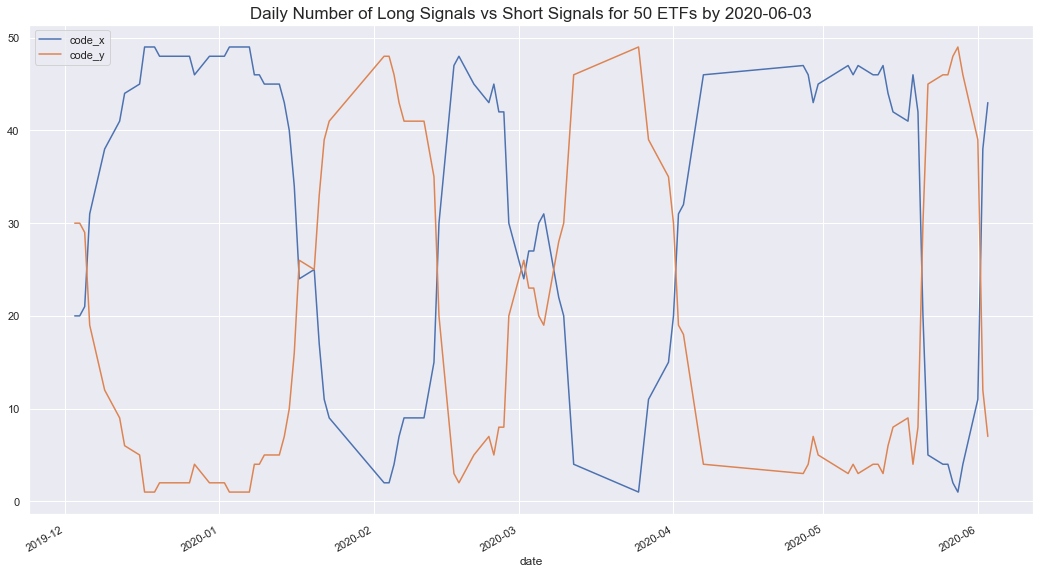

In [96]:
today = macd_long_short_counts[date_col].values[-1]
macd_long_short_counts[['code_x','code_y']].tail(100).plot(figsize = (18,10));
plt.title("Daily Number of Long Signals vs Short Signals for 50 ETFs by {}".format(today), fontsize = 17);

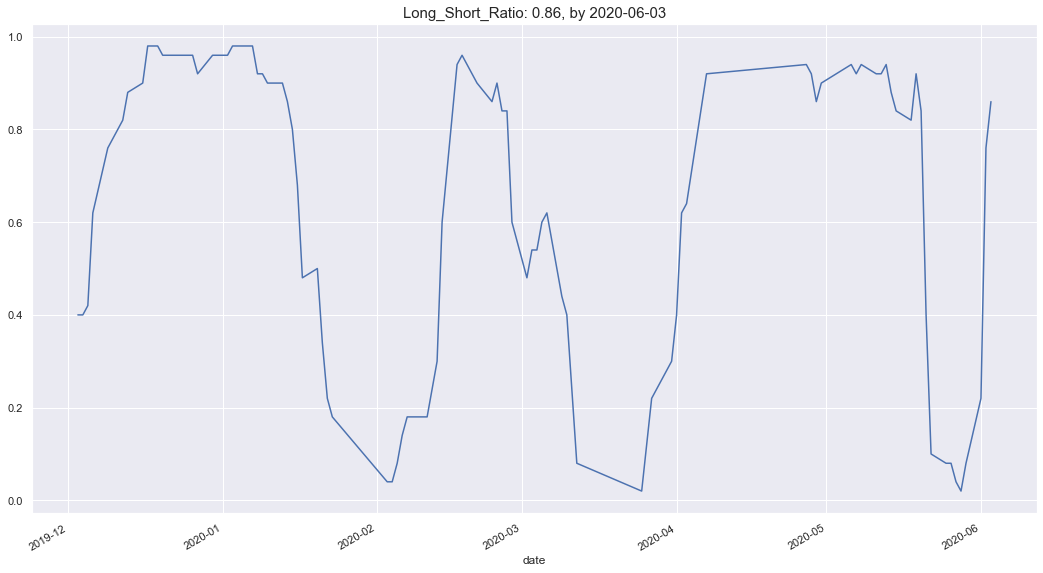

In [97]:
macd_long_short_counts['long_short_ratio'].tail(100).plot(figsize = (18,10))
long_short_ratio = macd_long_short_counts['long_short_ratio'].values[-1]
plt.title("Long_Short_Ratio: {}, by {}".format(round(long_short_ratio,2), today), fontsize =15);

In [98]:
# 在分析环境里，筛选出tickers，然后使用MACD_signals

class BIAS_signals(object):
    
    def __init__(self, stocks_path, tickers, date_col, code_col, price_col, n_fast, n_slow, n_macd, ticker_type):
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.ticker_type = ticker_type
    

    def get_mkt_data_df(self):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
        print(self.path)
        csv_path = self.path+"*.csv"
        files = glob.glob(csv_path)
        ticker_df_list = []
        for ticker in self.tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
        return tickers_data_concated
    

    def calc_macd_signals(self):
        tickers_data_concated = get_mkt_data_df(self.path, self.tickers, self.date_col)
        signal_record = []
        signal_data = []
        if len(self.tickers)!=1:
            for ticker in self.tickers:
                try:
                    if self.ticker_type == "float":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==float(ticker)]
                    elif self.ticker_type == "string":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==ticker]
                        
                    signal_df = MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)# 这个地方出错了
                    signal_data.append(signal_df)
                except:
                    pass
            signal_data_df = pd.concat(signal_data)
        else:
            try:                
                signal_df = MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
            except:
                pass
            signal_data_df = signal_df

        # v1 is the version of generating the og macd signals
        signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: make_numeric_signals(x))
        signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([self.code_col])['SIGNAL_DIRECTION'].diff()
        signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
        most_recent_signals = signal_data_df.groupby([self.code_col])[[self.date_col,self.code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
        return signal_data_df, most_recent_signals
    